## Evaluation of UTOPIA's performance in predicting MPs size dristributionsusing the monaco Monte Carlo framework 
#### (https://monaco.readthedocs.io/en/latest/)

With this script we preform an evaluation of UTOPIA's size distribution predictive capacity by comparing predicted size distributions in targeted compartmanes aginst observed MPs size distributions reported in the compilation of published datasets by Kooi et al.

### Import the necessary libraries

In [1]:
from utopia.monte_carlo.montecarlo_analysis_paper import run_mc_analysis_paper, set_emission, sim_to_dataframe, reshape_mc_results
from utopia.monte_carlo.monte_carlo_helpers import *
from utopia.utopia import utopiaModel
import numpy as np
import scipy.stats as st
import pandas as pd

c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:18: UserWarning: Consider installing numba for better performance
  warn("Consider installing numba for better performance", UserWarning)


### Load the UTOPIA's default configuration parameters 

In [2]:
data_data = utopiaModel.load_json_file("data/default_data.json")
config_data = utopiaModel.load_json_file("data/default_config.json")


### Define the parameter distributions for the Monte Carlo simulation.


In [3]:
# To reproduce Rakesh results, use these settings:

# Plastic density (mpdensity): [900, 1100, 1500] kg/m³ 
# Fragmentation style (FI): [0, 0.3, 0.5, 0.7, 1.0] - ranging from more erosive to more explosive fragmentation 
# Discorporation half time (thalf_deg): [316,1000,10000, 31600, 100000] days 
# Fragmentation timescale (thalf_frag): [10, 31.6, 100, 316] days

# param_distributions_discrete = {
#     "MPdensity_kg_m3": ("rv_discrete", {"values": ([900, 1100, 1500]        
#         , [1/3, 1/3, 1/3])}),
#     "FI": ("rv_discrete", {"values": ([0, 0.3, 0.5, 0.7, 1.0]        
#         , [0.2, 0.2, 0.2, 0.2, 0.2])}),
#     "t_half_deg_free": ("rv_discrete", {"values": ([316,1000,10000, 31600, 100000]        
#         , [0.2, 0.2, 0.2, 0.2, 0.2])}),
#     "t_frag_gen_FreeSurfaceWater": ("rv_discrete", {"values": ([10, 31.6, 100, 316]        
#         , [1/4, 1/4, 1/4, 1/4])})
# }

Transform the discrete distributions to continuous distributions for compatibility with the current montecarlo function

In [4]:
import numpy as np

# your discrete support values
vals_density = np.array([900, 1100, 1500])
vals_FI = np.array([0, 0.3, 0.5, 0.7, 1.0])
vals_deg = np.array([316, 1000, 10000, 31600, 100000])
vals_frag = np.array([10, 31.6, 100, 316])

def lognorm_params_from_values(values, sigma):
    """
    Return (s, scale) for scipy.stats.lognorm given target values.
    sigma = shape parameter (spread in log space).
    We center the lognormal at the geometric mean of the values.
    """
    mu = np.mean(np.log(values))  # geometric mean in log-space
    scale = np.exp(mu - (sigma**2) / 2)
    return sigma, scale

# choose sigma to control spread (tune manually!)
s_deg, scale_deg = lognorm_params_from_values(vals_deg, sigma=0.8)
s_frag, scale_frag = lognorm_params_from_values(vals_frag, sigma=0.5)
s_density, scale_density = lognorm_params_from_values(vals_density, sigma=0.1)
s_FI, scale_FI = lognorm_params_from_values(vals_FI[vals_FI > 0], sigma=0.5)  # avoid zero for lognorm

param_distributions = {
    "MPdensity_kg_m3": ("lognorm", {"s": s_density, "scale": scale_density}),
    "FI": ("uniform", {"loc": 0.0, "scale": 1.0}),
    "t_half_deg_free": ("lognorm", {"s": s_deg, "scale": scale_deg}),
    "t_frag_gen_FreeSurfaceWater": ("lognorm", {"s": s_frag, "scale": scale_frag})
}



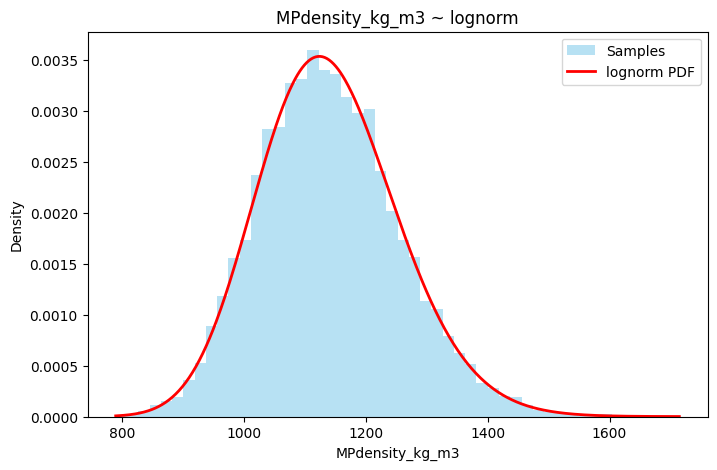

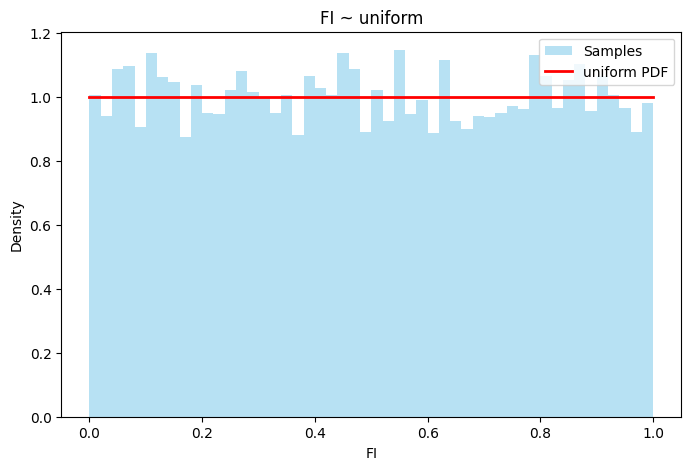

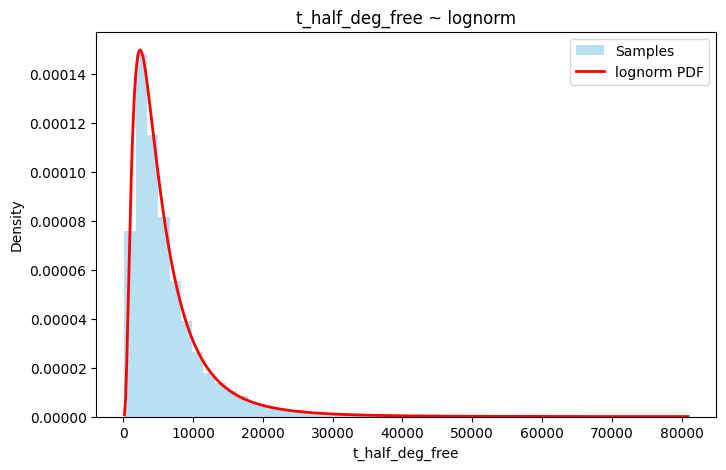

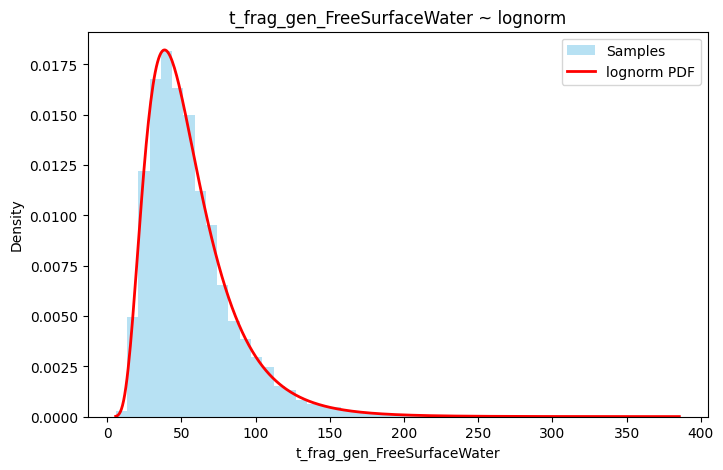

In [5]:
# Define the parameters that you want to sample from the input parameters included on the data loaded from the default data file and select a distribution for each parameter.
# param_distributions = {
#     "MPdensity_kg_m3": ("lognorm", {"s": 0.15, "scale": np.exp(np.log(data_data["MPdensity_kg_m3"]) - (0.05**2) / 2)}),
#     "FI": ("uniform", {"loc": 0.0, "scale": 1.0}),
#     "t_half_deg_free": ("lognorm", {"s": s_deg, "scale": scale_deg}),
#     "t_frag_gen_FreeSurfaceWater": ("lognorm", {"s": s_frag, "scale": scale_frag})
# }

for psrsm in param_distributions:
    plot_distribution_from_dict(psrsm, param_distributions)

In [6]:

# Recent studies have challenged the density of biofilm used here (1388 kg m-3) as being too high. see e.g. # https://doi.org/10.1186/s43591-024-00098-2 
# Consider testing chnages in biofouling density

In [7]:
# Set emission scenarios to run that are compatible for comparison with observations data from Kooi et al.

##############################################
# DEFINE ARTICLE -> EMISSION SCENARIOS
##############################################

overlay_emission_scenarios = {
    "Sea Sediment | Bergmann":["Ocean_Surface_Water","Coast_Surface_Water","Coast_Column_Water"],
    "Sea Surface all | Cai":["Surface_Freshwater","Coast_Surface_Water","Impacted_Soil_Surface"],
    "Sea Surface Fragments | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Sea Surface Fibers | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Fragments in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fragments in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Erni-Cassola":["Coast_Surface_Water","Impacted_Soil_Surface"],
    "Fresh water sediments | Imhof":["Surface_Freshwater","Impacted_Soil_Surface"],
    "Sea Surface all | Isobe L1":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L2":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L3":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L4":["Surface_Freshwater","Coast_Surface_Water"],
    "FP all | Scheurer":["Impacted_Soil_Surface"],
    "Sea Surface Fragments | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface Fibers | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Zhang":["Coast_Surface_Water","Surface_Freshwater"]}
    
    
    
    
# DEFINE ARTICLE->COMPARTMENTS MAPPING
#############################################
overlay_compartments_mapping = {
    "Sea Sediment | Bergmann": ["Sediment_Coast", "Sediment_Ocean"],
    "Sea Surface all | Cai": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fragments | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fragments in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fibers in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fragments in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil","Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Fibers in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil",
    "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Sea Surface all | Erni-Cassola": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fresh water sediments | Imhof": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Sea Surface all | Isobe L1": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L2": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L3": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe L4": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "FP all | Scheurer": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface Fragments | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Zhang": ["Coast_Surface_Water", "Ocean_Surface_Water"]
}

# NOTE! Maybe the mapping for the FP all | Scheurer study has to be revisited. Samples were collected in floodplain soils, so the impacted_soil_surface compartment might be more appropriate. Since the model does not simulate floodplain soils as a separate compartment.?

In [8]:
# Set emission scenarios according to the mapping defined above to the run the model for each parameter combination using the Monte Carlo framework and perform the comparison with the observed data according to mapping.

Test difference in results if run with distributions or single values for the parameters for one article

In [9]:
art= "Sea Surface Fibers | Song"
print(f"Running Monte Carlo analysis for article: {art}")


Running Monte Carlo analysis for article: Sea Surface Fibers | Song


In [10]:

MC_simulations_results=[]
for comp in overlay_emission_scenarios[art]:
    # Set emissions to that compartment and include it in base_data file
    data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
    
    
    #Run Monte Carlo analysis for each emission scenario and targer compartment
    for comp_T in overlay_compartments_mapping[art]:
        emission_comp=comp
        target_comp=comp_T
        sim= run_mc_analysis_paper(
        base_config=config_data,
        base_data=data_data,
        param_distributions=param_distributions,
        n_cases=100,art=art,emission_comp=emission_comp,target_comp=target_comp
    )
    
        # Convert sim results to dataframe
        df_MC_results = sim_to_dataframe(sim)
        
        
        MC_simulations_results.append(df_MC_results)
MC_simulations_results = pd.concat(MC_simulations_results, ignore_index=True)

Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 33272.28 cases/s]

Simulation complete! Runtime: 0:04:03.390977
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 12853.74 cases/s]

Simulation complete! Runtime: 0:04:11.705611
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 5522.96 cases/s]

Simulation complete! Runtime: 0:04:18.463080
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 6440.88 cases/s]

Simulation complete! Runtime: 0:04:26.428567


In [11]:
MC_simulations_results

,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,Spearman_r,Spearman_p,Pass_Spearman,RMSE,R_squared,Model_slope,Model_intercept,Target_compartment,Emission_compartment
0,1223.294660,0.054891,5884.711542,30.044884,-1.0,0.0,True,3.583584,-142.816901,-4.053345,8.180425,Coast_Surface_Water,Impacted_Soil_Surface
1,1027.531967,0.740818,2868.534938,54.291047,-1.0,0.0,True,3.073800,-104.809789,-4.170501,9.020901,Coast_Surface_Water,Impacted_Soil_Surface
2,1112.195170,0.330629,21172.690691,47.313693,-1.0,0.0,True,3.807605,-161.359744,-4.457514,9.072681,Coast_Surface_Water,Impacted_Soil_Surface
3,1142.043586,0.902573,1849.708321,75.362682,-1.0,0.0,True,3.261210,-118.105626,-4.172318,8.835902,Coast_Surface_Water,Impacted_Soil_Surface
4,1183.945885,0.387262,3693.020138,117.716668,-1.0,0.0,True,3.779504,-158.972103,-4.237836,8.492999,Coast_Surface_Water,Impacted_Soil_Surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1231.166859,0.851008,6058.951788,27.518399,-1.0,0.0,True,3.154276,-110.422752,-3.752840,7.782639,Ocean_Surface_Water,Surface_Freshwater
396,1238.635520,0.233781,11352.757679,45.146966,-1.0,0.0,True,3.754868,-156.893403,-3.843504,7.427404,Ocean_Surface_Water,Surface_Freshwater
397,1019.089303,0.532990,993.879397,81.458540,NaN,NaN,False,NaN,NaN,NaN,NaN,Ocean_Surface_Water,Surface_Freshwater
398,1099.600655,0.380620,7326.505206,32.499436,-1.0,0.0,True,3.780299,-159.039427,-3.932559,7.647905,Ocean_Surface_Water,Surface_Freshwater


In [19]:
#Tidy dataframe

input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]
tidy_mc_results=reshape_mc_results(MC_simulations_results, input_params, art)
tidy_mc_results

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater
0,0,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,3.583584,-142.816901,-4.053345,-1.0,True,1223.294660,0.054891,5884.711542,30.044884
1,1,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,3.073800,-104.809789,-4.170501,-1.0,True,1027.531967,0.740818,2868.534938,54.291047
2,2,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,3.807605,-161.359744,-4.457514,-1.0,True,1112.195170,0.330629,21172.690691,47.313693
3,3,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,3.261210,-118.105626,-4.172318,-1.0,True,1142.043586,0.902573,1849.708321,75.362682
4,4,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,3.779504,-158.972103,-4.237836,-1.0,True,1183.945885,0.387262,3693.020138,117.716668
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,3.154276,-110.422752,-3.752840,-1.0,True,1231.166859,0.851008,6058.951788,27.518399
396,396,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,3.754868,-156.893403,-3.843504,-1.0,True,1238.635520,0.233781,11352.757679,45.146966
397,397,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,NaN,False,1019.089303,0.532990,993.879397,81.458540
398,398,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,3.780299,-159.039427,-3.932559,-1.0,True,1099.600655,0.380620,7326.505206,32.499436


In [29]:
# Sort ascending by RMSE (best fits first)
results_sorted_art = tidy_mc_results.sort_values("RMSE", ascending=True)

# Keep e.g. top 20 best-fitting combinations
top_results_art = results_sorted_art.head(10)


In [21]:
top_results_art

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater
206,206,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.136626,0.790954,-1.068090,-1.0,True,938.199911,0.224775,770.506012,61.797943
306,306,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,0.143978,0.767850,-1.561945,-1.0,True,938.199911,0.224775,770.506012,61.797943
322,322,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,0.151235,0.743858,-1.197899,-1.0,True,990.707153,0.296573,3383.747878,28.018064
241,241,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.163241,0.701575,-1.053668,-1.0,True,980.681203,0.663796,2039.395314,39.332839
341,341,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,0.177235,0.648218,-1.361297,-1.0,True,980.681203,0.663796,2039.395314,39.332839
325,325,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,0.298415,0.002721,-1.110565,-1.0,True,970.257514,0.520478,5338.961256,45.756163
270,270,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.466686,-1.439072,-0.871266,-1.0,True,886.018832,0.323868,6710.695411,40.873903
238,238,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.521407,-2.044591,-0.850221,-1.0,True,954.198820,0.403270,15119.274827,27.333956
283,283,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.651308,-3.750593,-1.650555,-1.0,True,1155.066432,0.992368,9790.840879,65.294390
186,186,Sea Surface Fibers | Song,Impacted_Soil_Surface,Ocean_Surface_Water,0.686642,-4.280021,-2.152111,-1.0,True,976.044206,0.127168,19915.700294,78.726443


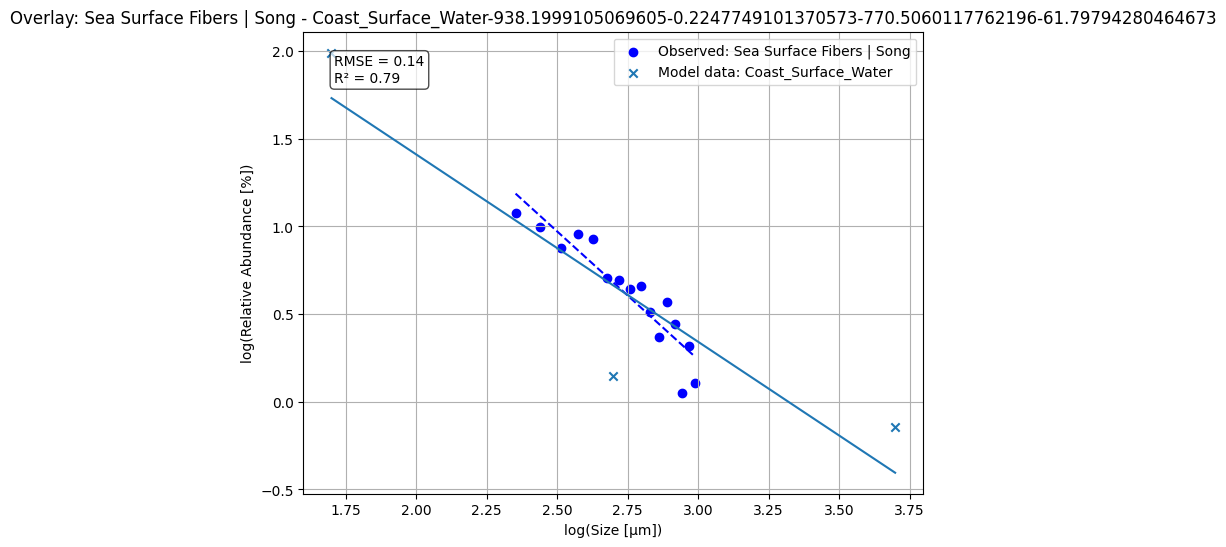

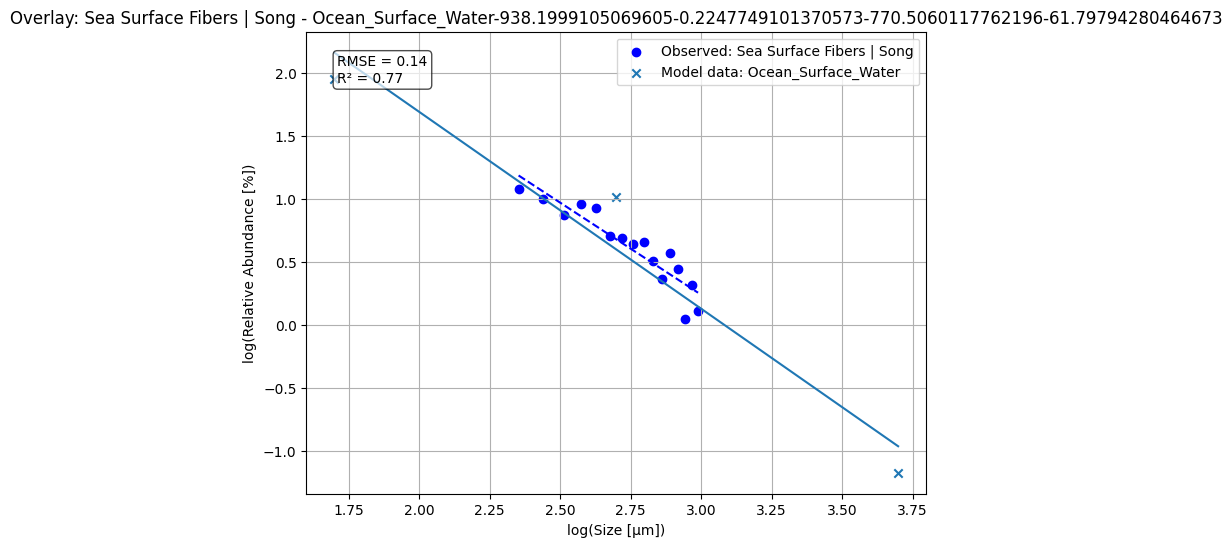

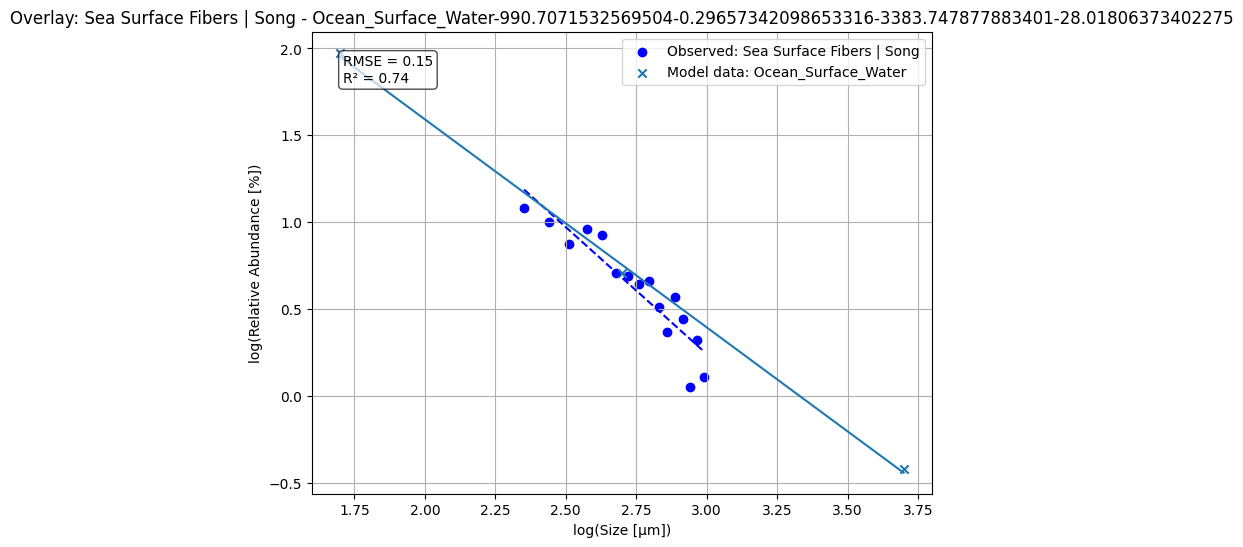

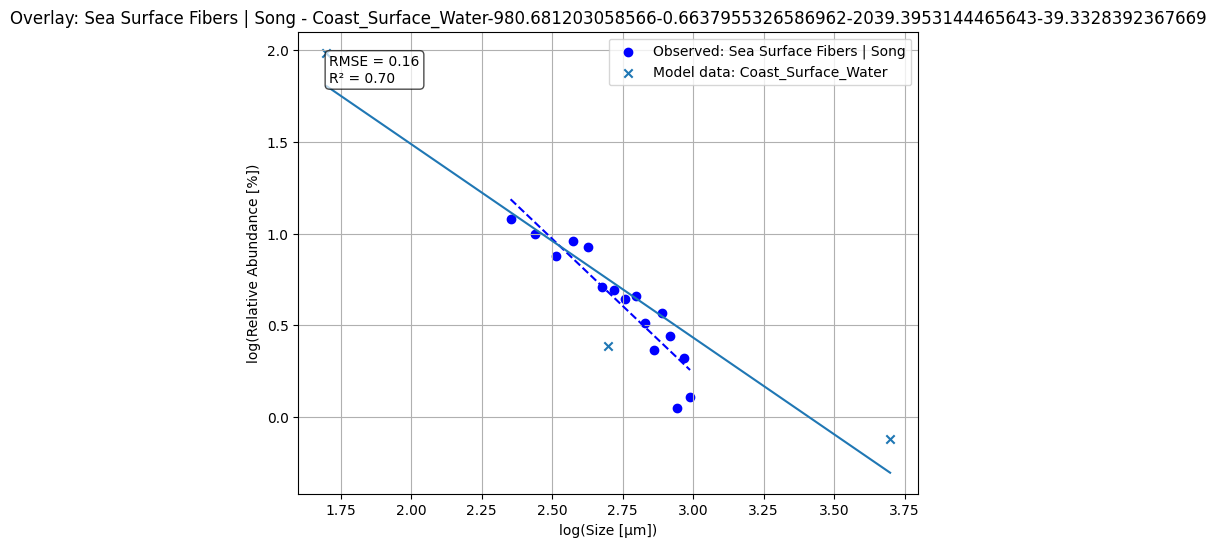

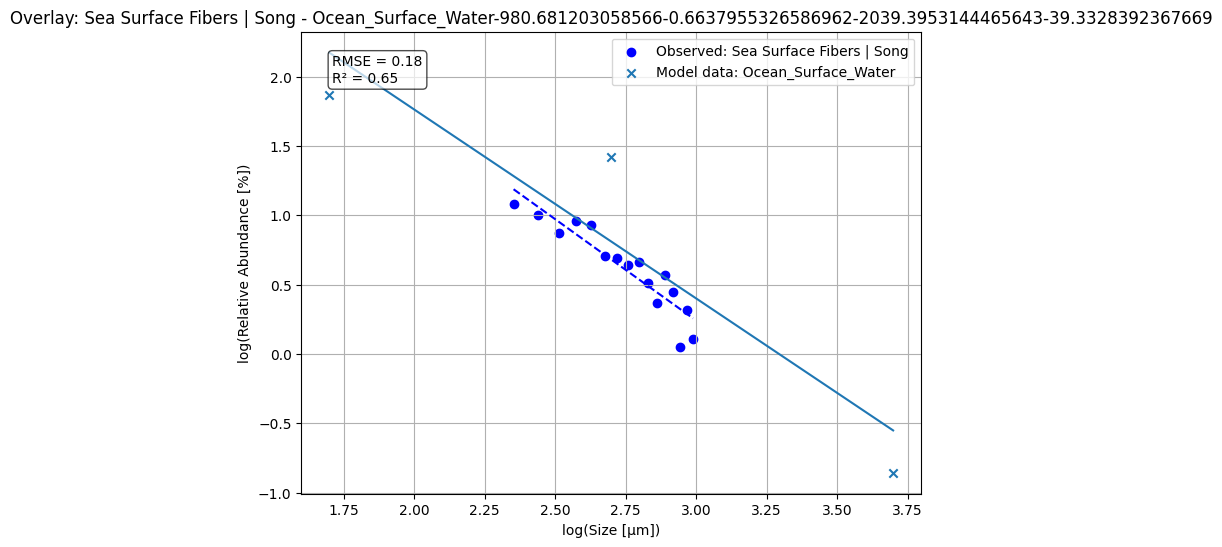

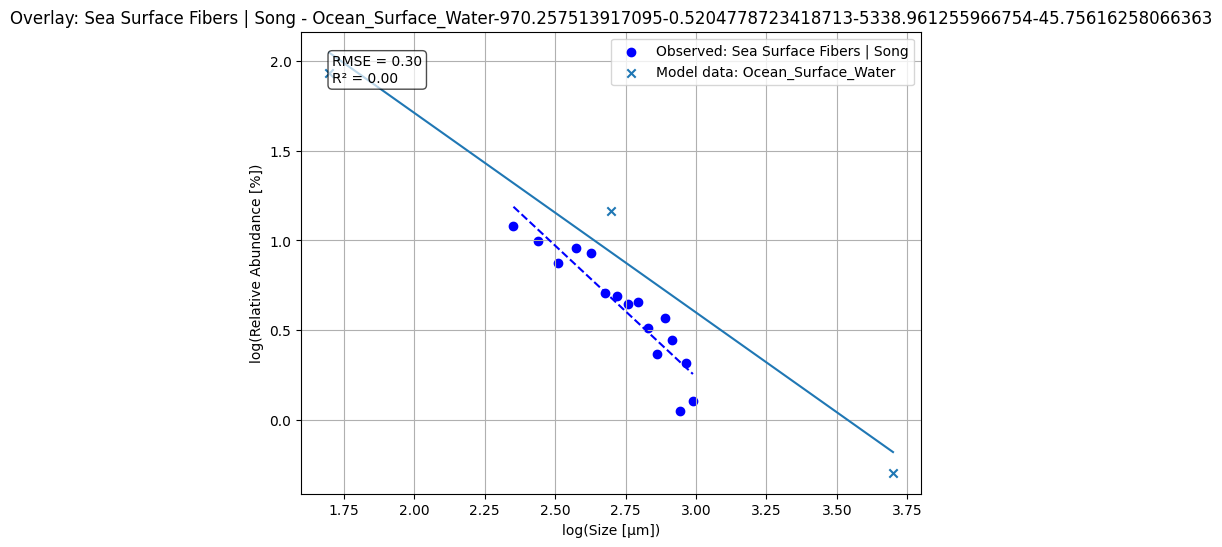

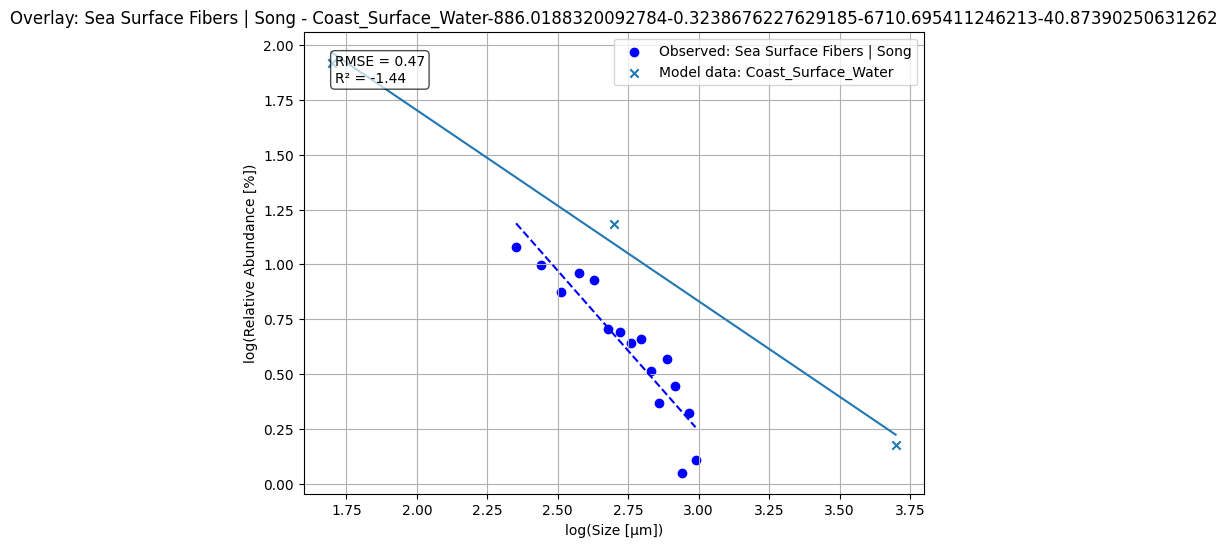

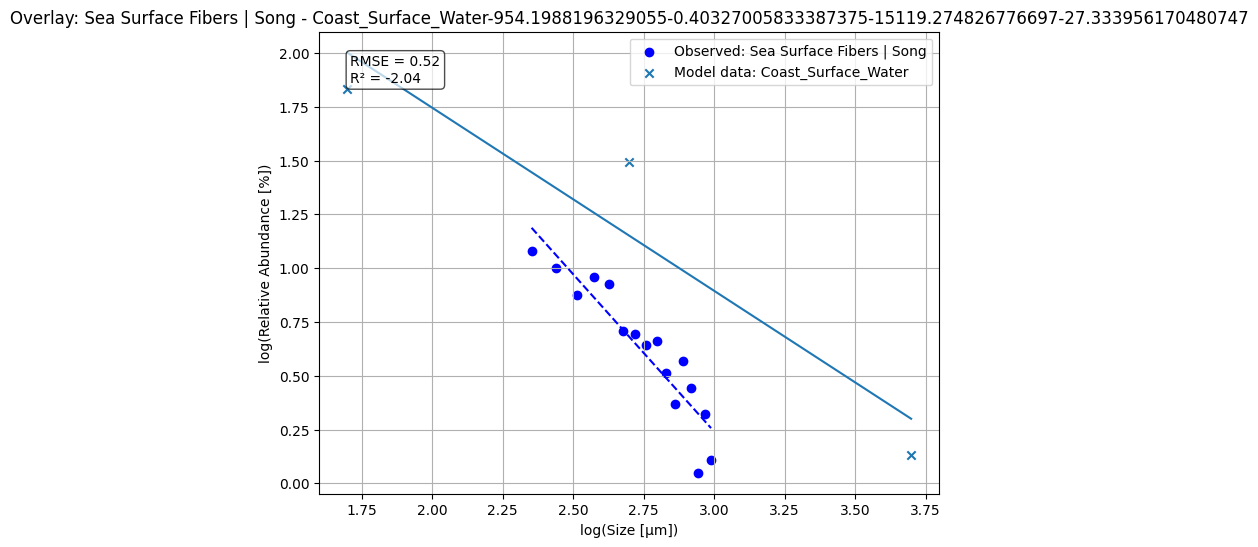

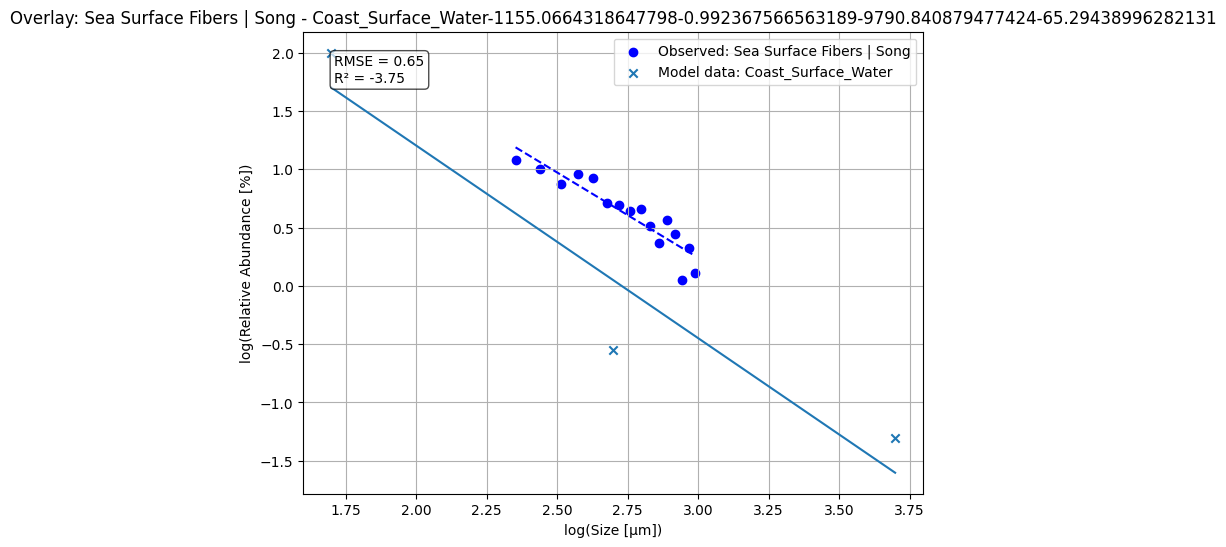

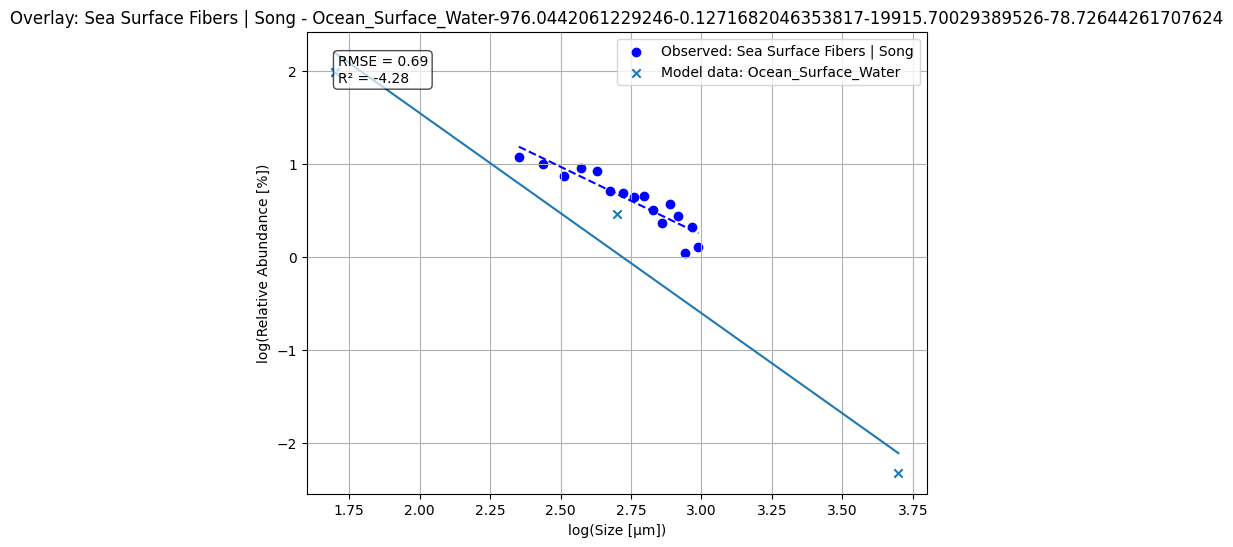

In [22]:

from utopia.monte_carlo.montecarlo_analysis_paper import run_and_plot_top_results
run_and_plot_top_results(top_results_art,data_data, config_data)

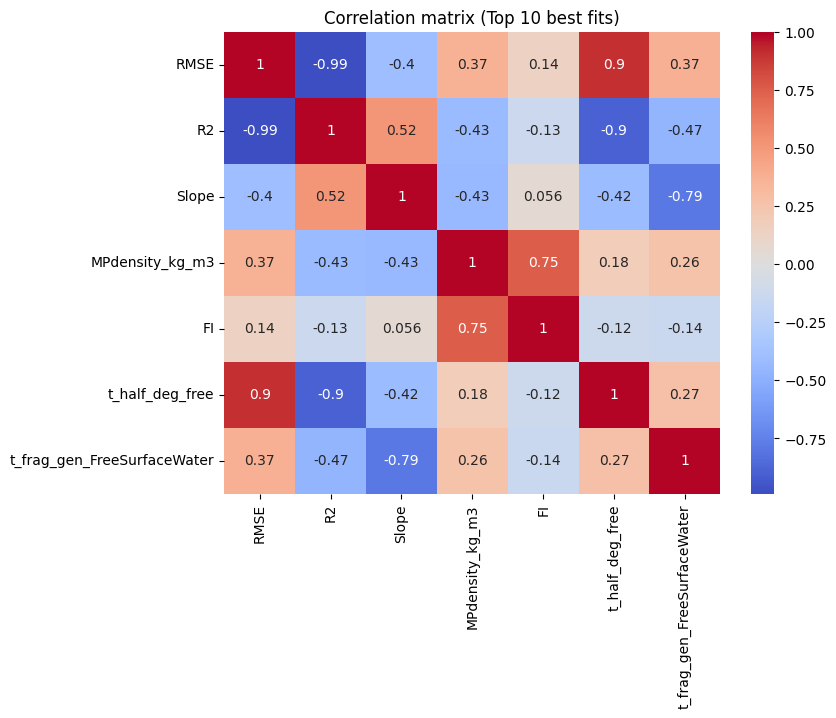

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = top_results_art[["RMSE", "R2", "Slope", "MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 10 best fits)")
plt.show()

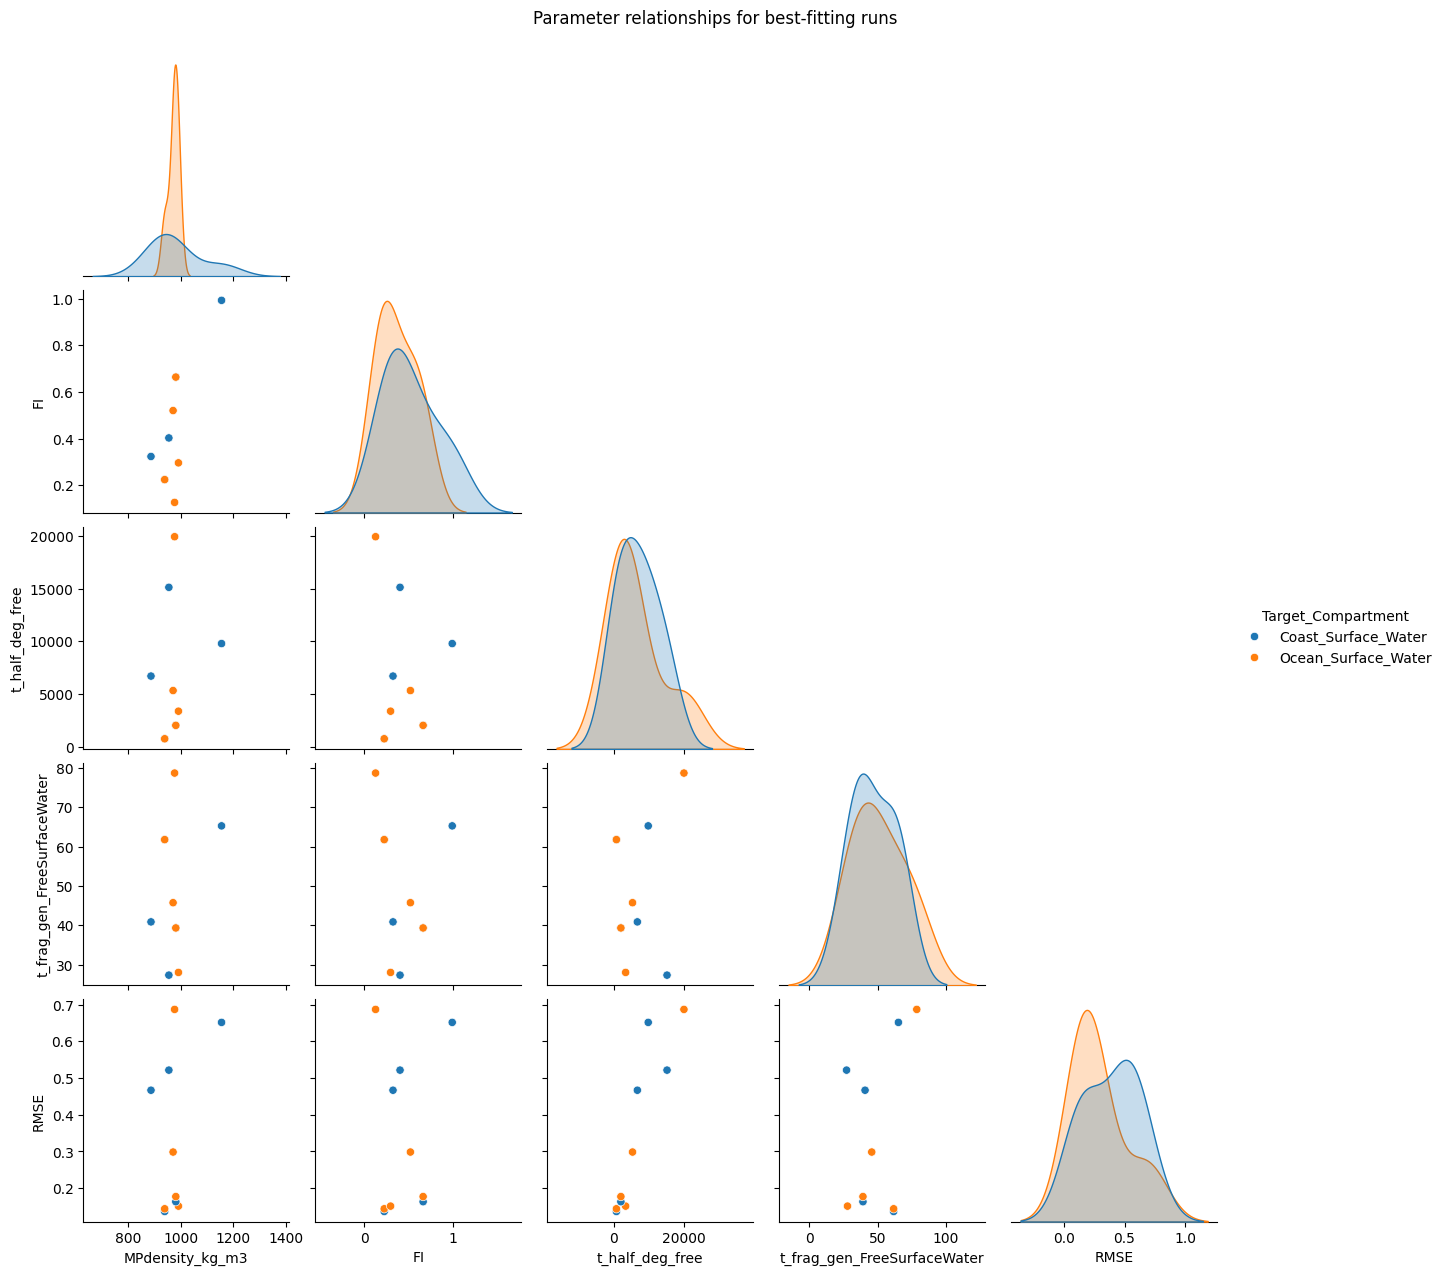

In [33]:
# Pair-wise relationships for the top results
sns.pairplot(
    top_results_art,
    vars=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","RMSE"],
    hue="Target_Compartment",
    corner=True
)
plt.suptitle("Parameter relationships for best-fitting runs", y=1.02)
plt.show()

Pearson r = 0.491, p = 2.785e-02
Spearman ρ = 0.331, p = 1.543e-01


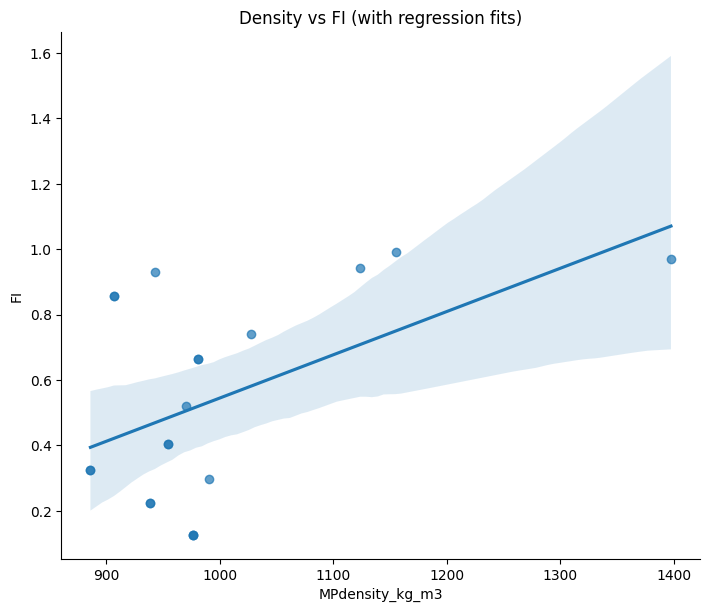

In [28]:
# Pearson & Spearman correlation between Density and FI for all results

# Pearson tests linear correlation.

# Spearman tests monotonic correlation (rank-based, robust to nonlinearities).

# If p < 0.05, the correlation is statistically significant.

from scipy.stats import pearsonr, spearmanr

x = top_results_art["MPdensity_kg_m3"]
y = top_results_art["FI"]

pearson_corr, pearson_p = pearsonr(x, y)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson r = {pearson_corr:.3f}, p = {pearson_p:.3e}")
print(f"Spearman ρ = {spearman_corr:.3f}, p = {spearman_p:.3e}")

import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=top_results_art, 
    x="MPdensity_kg_m3", 
    y="FI", 
    #hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()

In [54]:
# Run the Monte Carlo analysis with the specified parameters distributions and number of cases for specified emission scenarios related to the obsserved data from articles in the list.

all_results = [] 

# Run the Monte Carlo analysis for each article and emission scenario
for art in overlay_emission_scenarios: 
    for comp in overlay_emission_scenarios[art]:
        # Set emissions to that compartment and include it in base_data file
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
        
        #Run Monte Carlo analysis for each emission scenario and target compartment
        for comp_T in overlay_compartments_mapping[art]:
            emission_comp=comp
            target_comp=comp_T
            sim= run_mc_analysis_paper(
            base_config=config_data,
            base_data=data_data,
            param_distributions=param_distributions,
            n_cases=100,art=art,emission_comp=emission_comp,target_comp=target_comp
        )
        
        
            # Convert sim results to dataframe
            df_MC_results = sim_to_dataframe(sim)
            #Tidy dataframe
            input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"] # "overall_persistence_mass"...
            tidy_mc_results_df=reshape_mc_results(df_MC_results, input_params, art)
            
            all_results.append(tidy_mc_results_df)
        
        

results_df = pd.concat(all_results, ignore_index=True)



Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:   6%|▌         | 6/100 [00:14<03:58,  2.54s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [00:22<03:53,  2.56s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [01:02<04:01,  3.10s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [01:10<03:37,  2.91s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-pa

Simulation complete! Runtime: 0:04:19.456962
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   6%|▌         | 6/100 [00:16<04:26,  2.84s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [00:23<03:48,  2.51s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [00:55<03:00,  2.32s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [01:01<02:51,  2.29s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-p

Simulation complete! Runtime: 0:03:57.309885
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   6%|▌         | 6/100 [00:13<03:32,  2.26s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [00:20<03:21,  2.22s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [00:49<03:02,  2.34s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [00:56<02:55,  2.34s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-p

Simulation complete! Runtime: 0:04:02.361677
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   6%|▌         | 6/100 [00:13<03:33,  2.27s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [00:21<03:35,  2.37s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [00:49<02:50,  2.19s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [00:56<02:43,  2.18s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-p

Simulation complete! Runtime: 0:03:53.761866
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   6%|▌         | 6/100 [00:15<04:07,  2.63s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [00:23<03:42,  2.45s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [00:55<03:16,  2.52s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [01:03<03:11,  2.55s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-p

Simulation complete! Runtime: 0:04:15.380131
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   6%|▌         | 6/100 [00:15<04:05,  2.61s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [00:23<04:00,  2.64s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [00:55<03:12,  2.47s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [01:03<03:13,  2.59s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-p

Simulation complete! Runtime: 0:04:21.043602
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 7470.22 cases/s]

Simulation complete! Runtime: 0:04:18.831870
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 25536.10 cases/s]

Simulation complete! Runtime: 0:04:19.210266
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 5431.84 cases/s]

Simulation complete! Runtime: 0:04:18.662856
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 7126.14 cases/s]

Simulation complete! Runtime: 0:04:23.507424
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 24998.83 cases/s]

Simulation complete! Runtime: 0:04:26.758737
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 5124.69 cases/s]

Simulation complete! Runtime: 0:04:26.798200
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 12504.63 cases/s]

Simulation complete! Runtime: 0:04:27.077325
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 11128.43 cases/s]

Simulation complete! Runtime: 1:03:34.311611
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 6915.13 cases/s]

Simulation complete! Runtime: 0:03:32.291466
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 7817.17 cases/s]

Simulation complete! Runtime: 0:03:35.575812
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 8247.90 cases/s]

Simulation complete! Runtime: 0:03:45.582368
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:03:27.504247
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:03:36.753011
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 29002.24 cases/s]

Simulation complete! Runtime: 0:03:35.947950
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 4300.53 cases/s]

Simulation complete! Runtime: 0:04:20.840305
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 8529.52 cases/s]

Simulation complete! Runtime: 0:04:17.174005
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 53911.36 cases/s]

Simulation complete! Runtime: 0:04:23.838250
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 11323.10 cases/s]

Simulation complete! Runtime: 0:04:26.683139
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 12350.72 cases/s]

Simulation complete! Runtime: 0:04:21.450314
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 6632.99 cases/s]

Simulation complete! Runtime: 0:04:24.925985
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 6557.39 cases/s]

Simulation complete! Runtime: 0:03:51.012719
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 2989.04 cases/s]

Simulation complete! Runtime: 3:46:29.369416
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...


Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:   6%|▌         | 6/100 [00:44<11:23,  7.27s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [01:04<10:24,  6.86s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [02:37<09:33,  7.35s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [02:57<08:36,  6.89s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-pa

Simulation complete! Runtime: 2:27:53.437509
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   6%|▌         | 6/100 [00:18<04:27,  2.84s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:   9%|▉         | 9/100 [00:27<04:25,  2.92s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [01:09<04:18,  3.31s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [01:19<03:56,  3.16s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-p

Simulation complete! Runtime: 1:46:47.470379
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 17331.83 cases/s]

Simulation complete! Runtime: 4:07:05.064792
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 100/100 [00:00<00:00, 13695.69 cases/s]

Simulation complete! Runtime: 0:45:46.156818
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   6%|▌         | 6/100 [00:17<04:33,  2.91s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  22%|██▏       | 22/100 [01:01<03:33,  2.74s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  25%|██▌       | 25/100 [01:09<03:24,  2.73s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  38%|███▊      | 38/100 [1:30:03<3:16:04, 189.74s/ cases]  c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Li

Simulation complete! Runtime: 3:13:28.599977
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 100/100 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:   0%|          | 0/100 [00:00<?, ? cases/s]

KeyboardInterrupt: 

In [55]:
all_results


[    Case         Observed_dataset Emission_Compartment Target_Compartment  \
 0      0  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 1      1  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 2      2  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 3      3  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 4      4  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 ..   ...                      ...                  ...                ...   
 95    95  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 96    96  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 97    97  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 98    98  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 99    99  Sea Sediment | Bergmann  Ocean_Surface_Water     Sediment_Coast   
 
         RMSE         R2     Slope  Spearman_r  Pass_Spearman 

In [9]:
# Sort ascending by RMSE (best fits first)
results_sorted_all = results_df.sort_values("RMSE", ascending=True)

# Keep e.g. top 20 best-fitting combinations
top_results = results_sorted_all.head(20)


In [10]:

top_results

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater
1213,13,Sea Surface all | Isobe L2,Surface_Freshwater,Coast_Surface_Water,0.186895,0.567600,-1.106920,-1.0,True,961.519499,0.603366,4384.922339,22.091539
454,14,Fragments in water | Eo,Surface_Freshwater,Bulk_Freshwater,0.187929,0.926856,-1.953069,-1.0,True,856.834375,0.450996,4610.300644,56.050699
1293,13,Sea Surface all | Isobe L3,Surface_Freshwater,Coast_Surface_Water,0.188085,0.552097,-1.106920,-1.0,True,961.519499,0.603366,4384.922339,22.091539
1202,2,Sea Surface all | Isobe L2,Surface_Freshwater,Coast_Surface_Water,0.189423,0.555822,-0.976781,-1.0,True,949.180258,0.330629,5037.980205,30.721058
1282,2,Sea Surface all | Isobe L3,Surface_Freshwater,Coast_Surface_Water,0.189570,0.544999,-0.976781,-1.0,True,949.180258,0.330629,5037.980205,30.721058
446,6,Fragments in water | Eo,Surface_Freshwater,Bulk_Freshwater,0.191544,0.924015,-2.016675,-1.0,True,735.394318,0.224775,4095.613401,40.125766
1350,10,Sea Surface all | Isobe L3,Coast_Surface_Water,Ocean_Surface_Water,0.196613,0.510561,-0.919336,-1.0,True,928.013133,0.118571,4555.026552,7.845831
523,3,Fibers in water | Eo,Surface_Freshwater,Bulk_Freshwater,0.197610,0.417037,-1.078888,-1.0,True,987.645770,0.902573,4326.028802,48.933431
450,10,Fragments in water | Eo,Surface_Freshwater,Bulk_Freshwater,0.197911,0.918880,-1.938019,-1.0,True,928.013133,0.118571,4555.026552,7.845831
1294,14,Sea Surface all | Isobe L3,Surface_Freshwater,Coast_Surface_Water,0.199559,0.495782,-0.940302,-1.0,True,856.834375,0.450996,4610.300644,56.050699


From top results run model and plot overlays with observed data

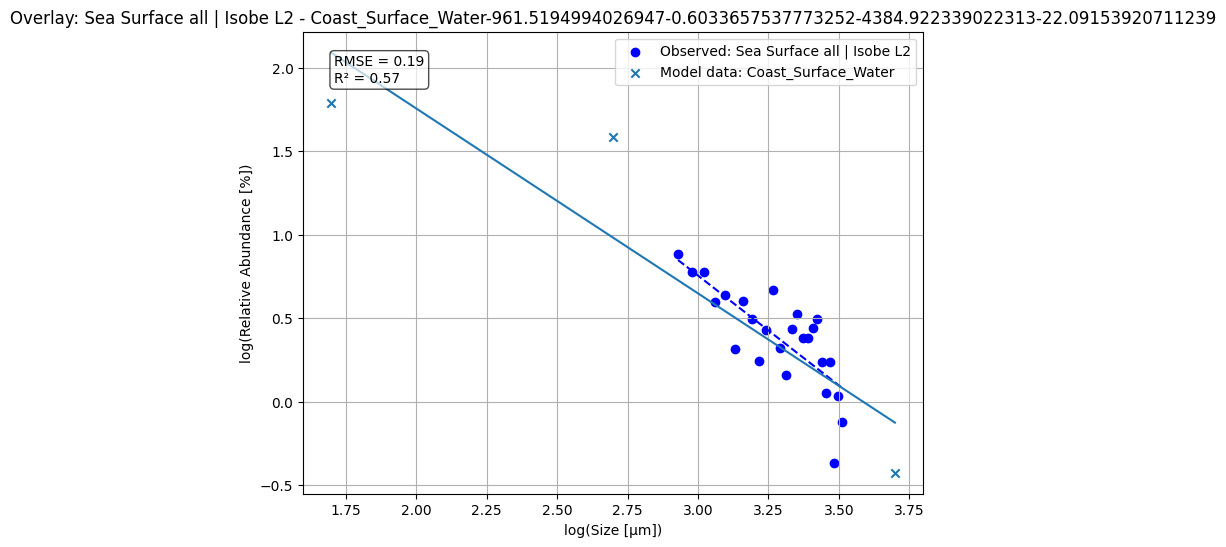

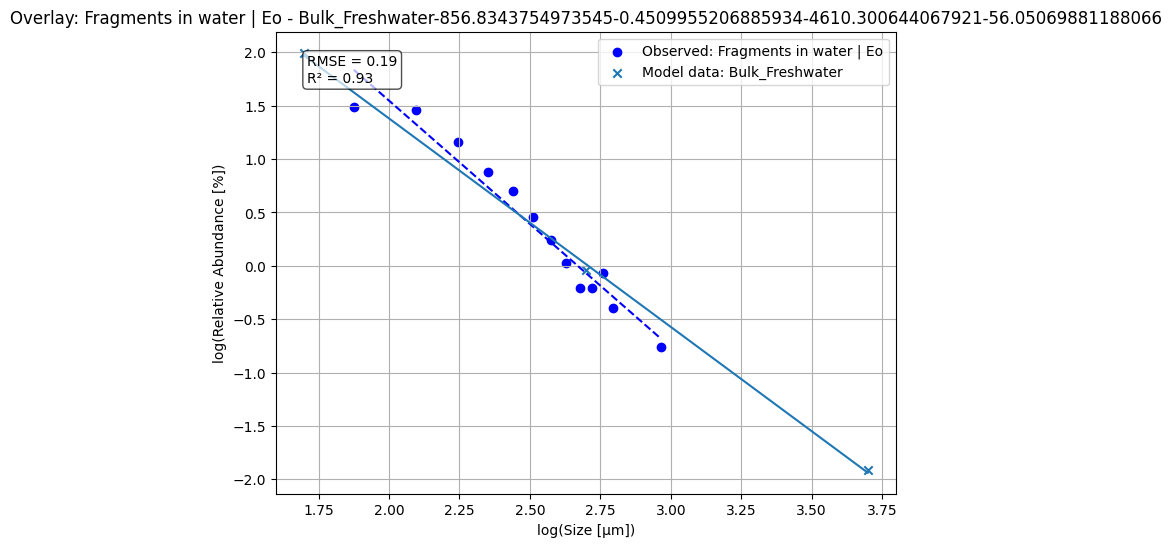

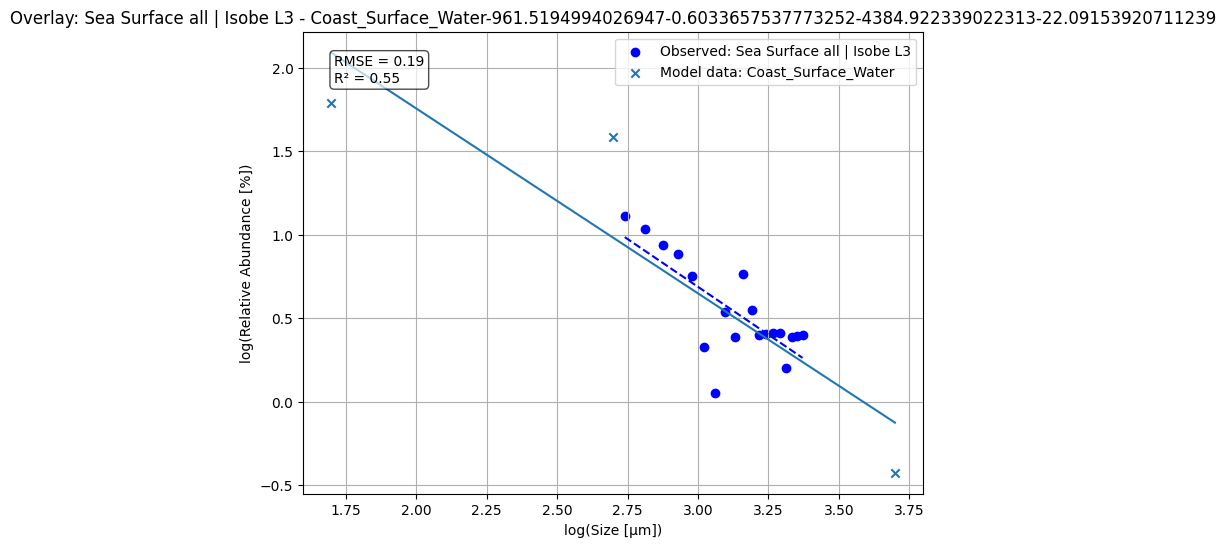

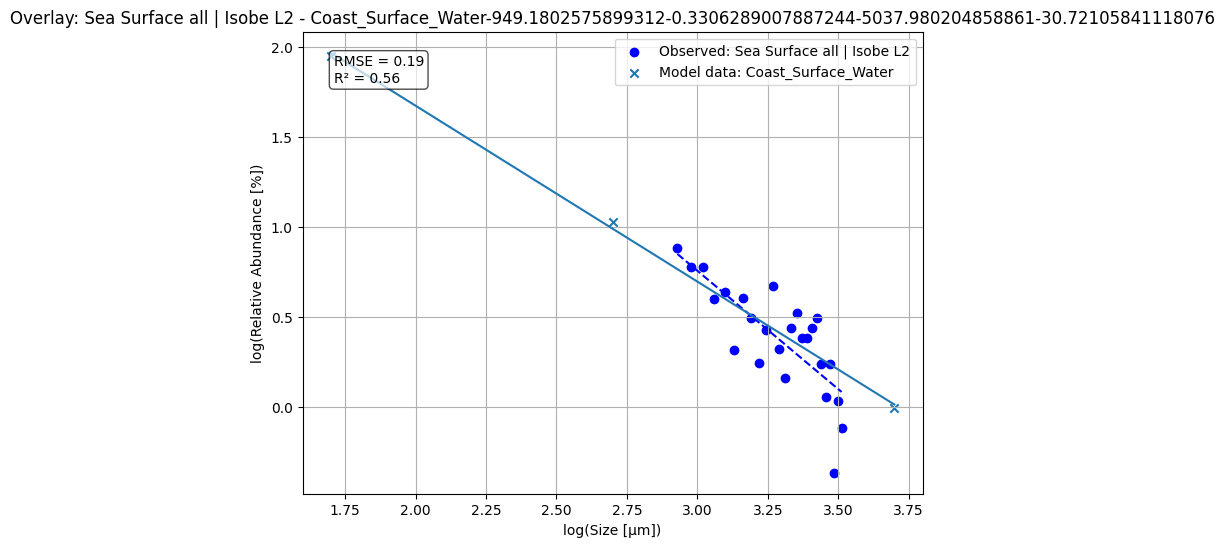

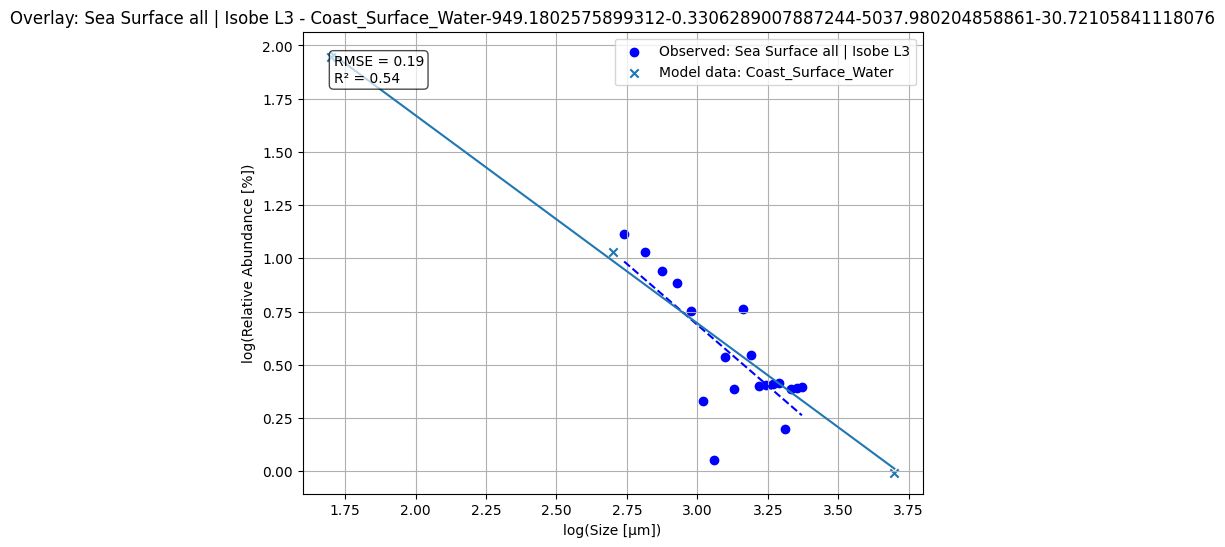

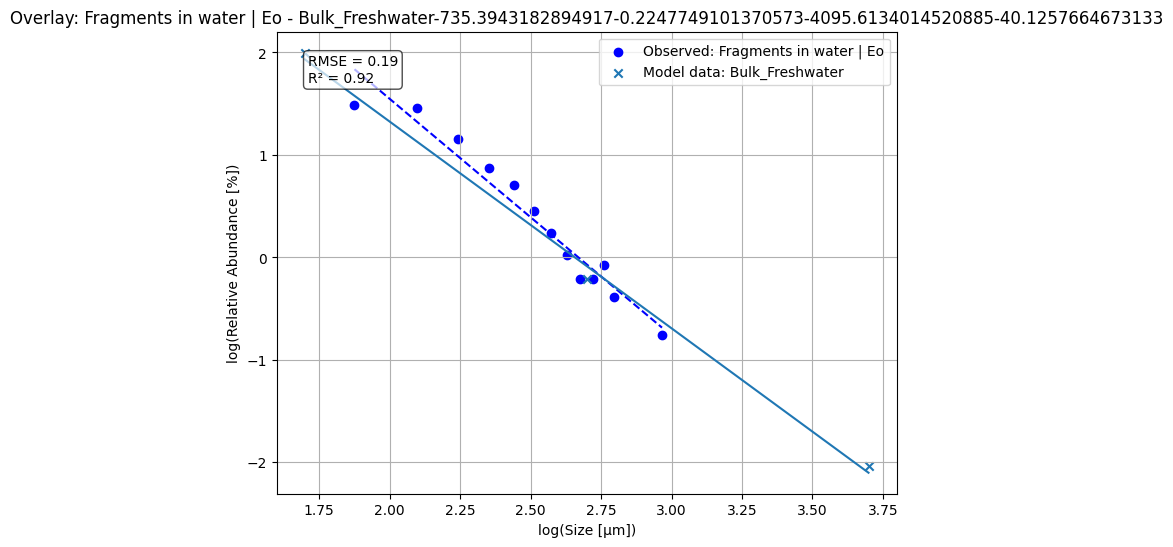

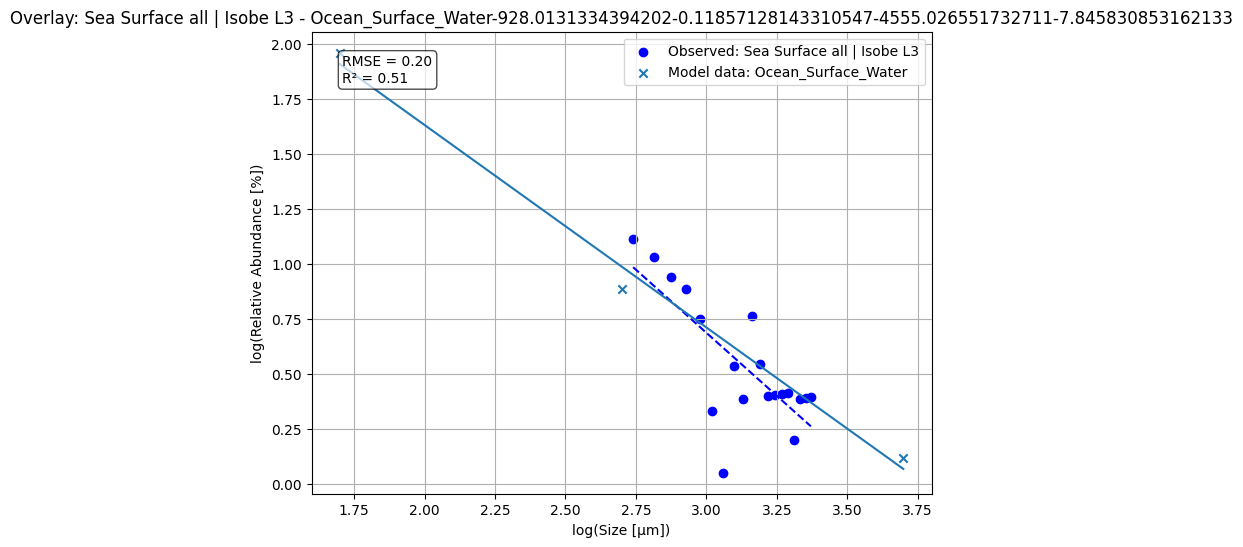

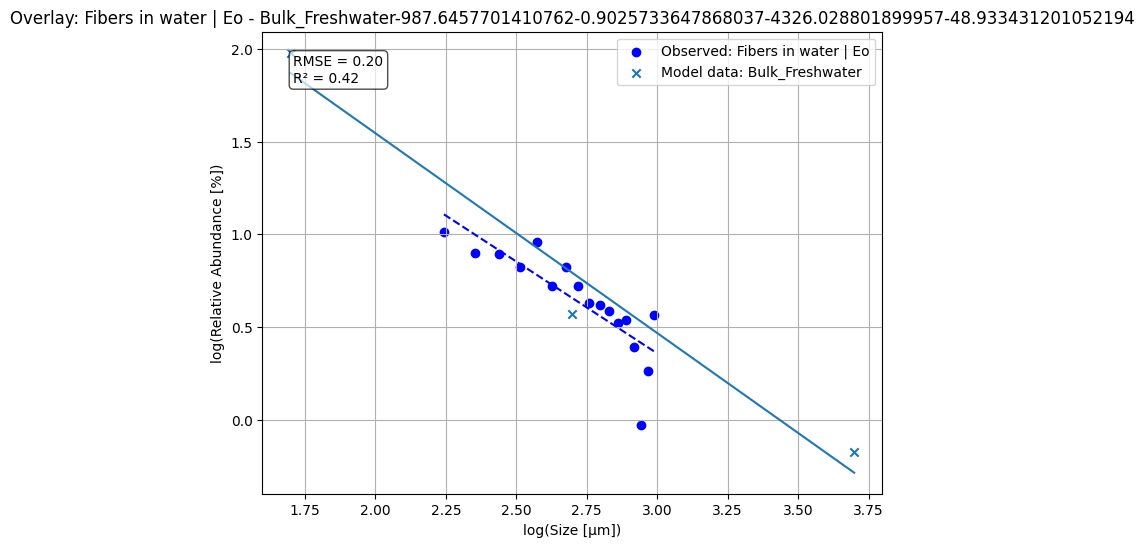

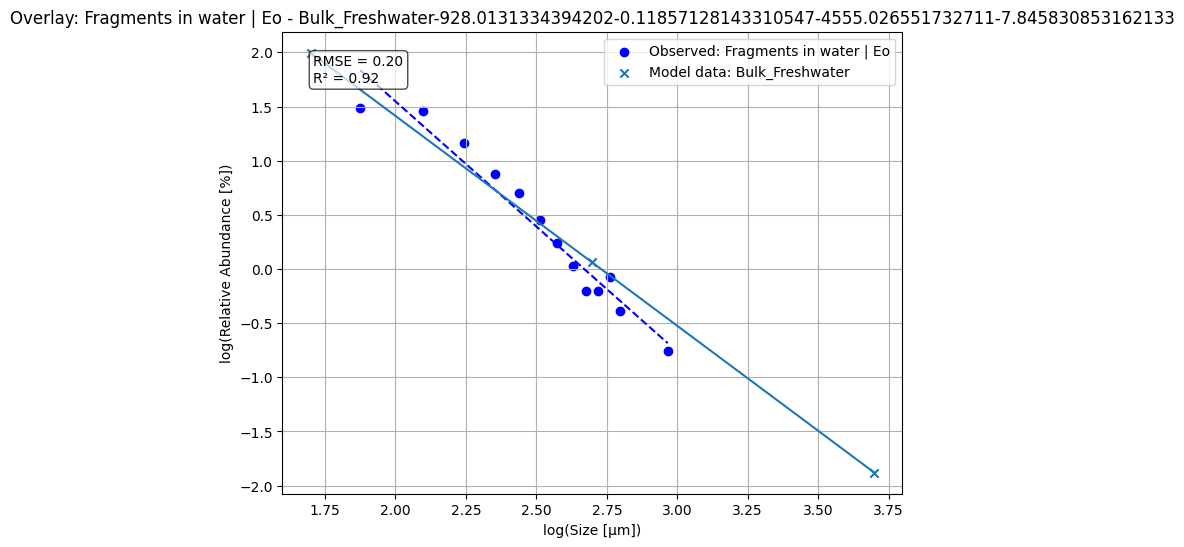

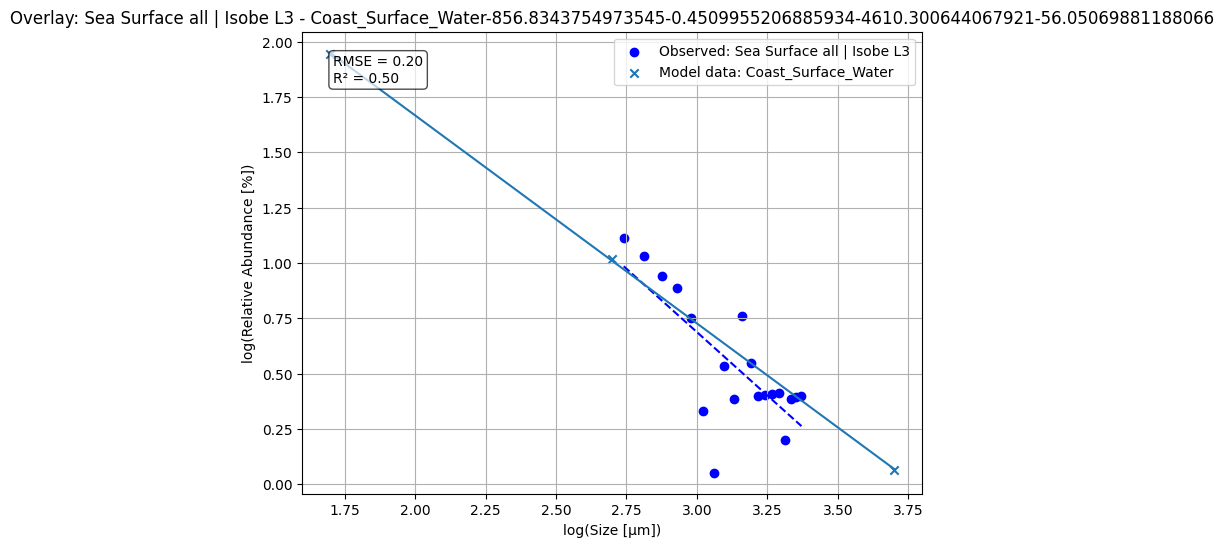

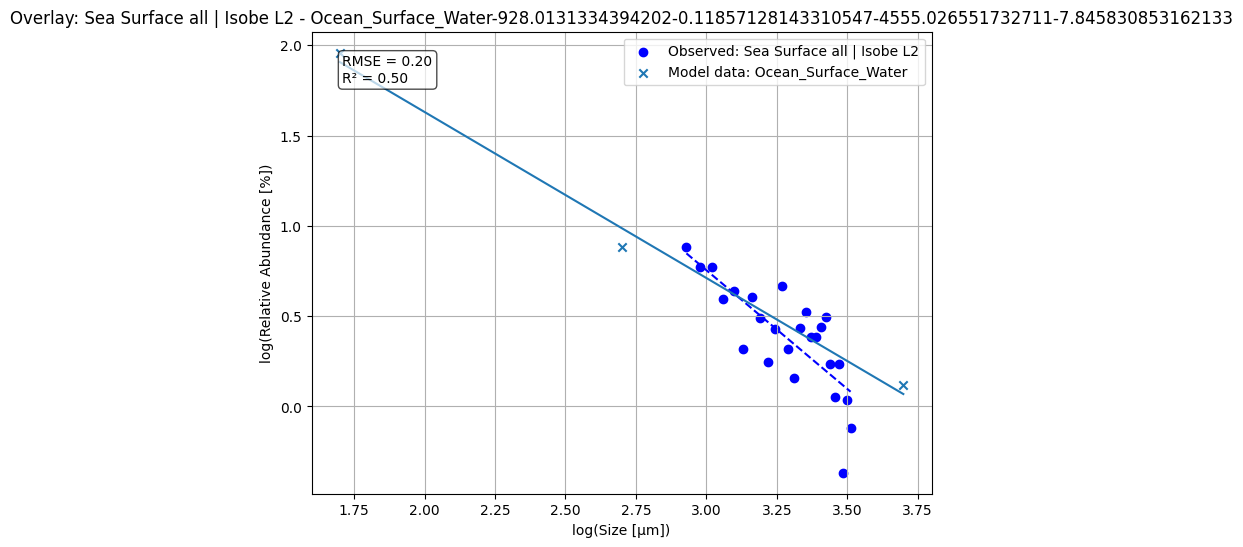

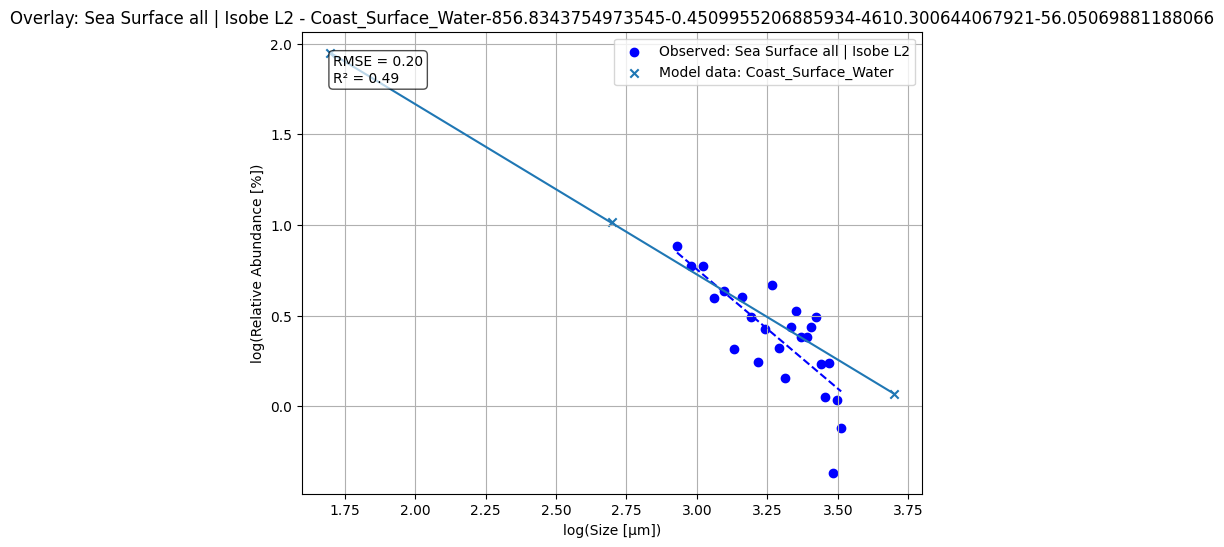

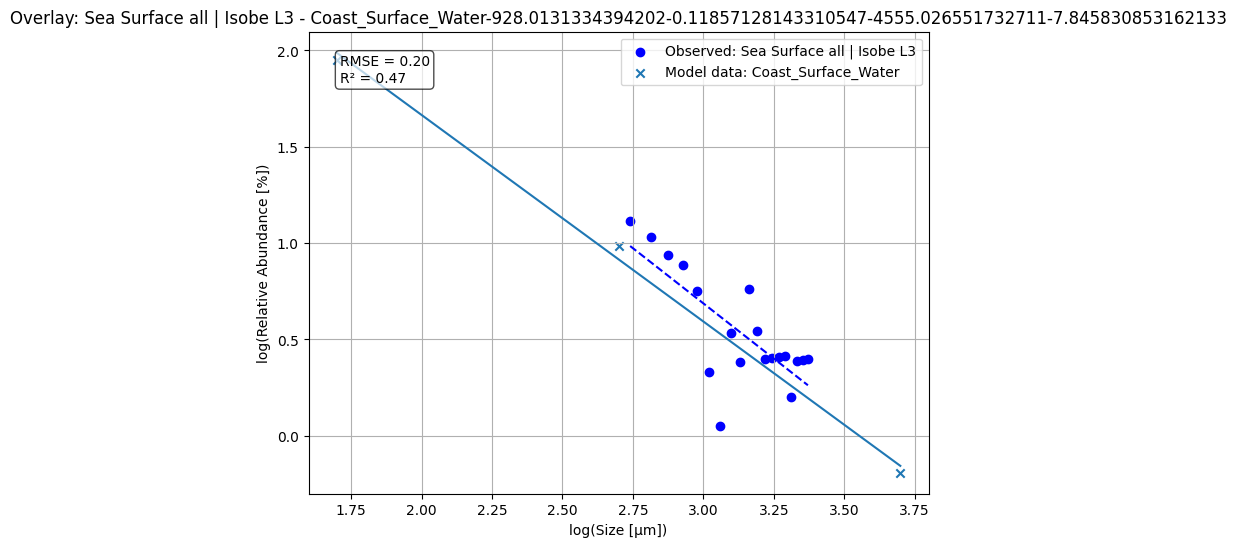

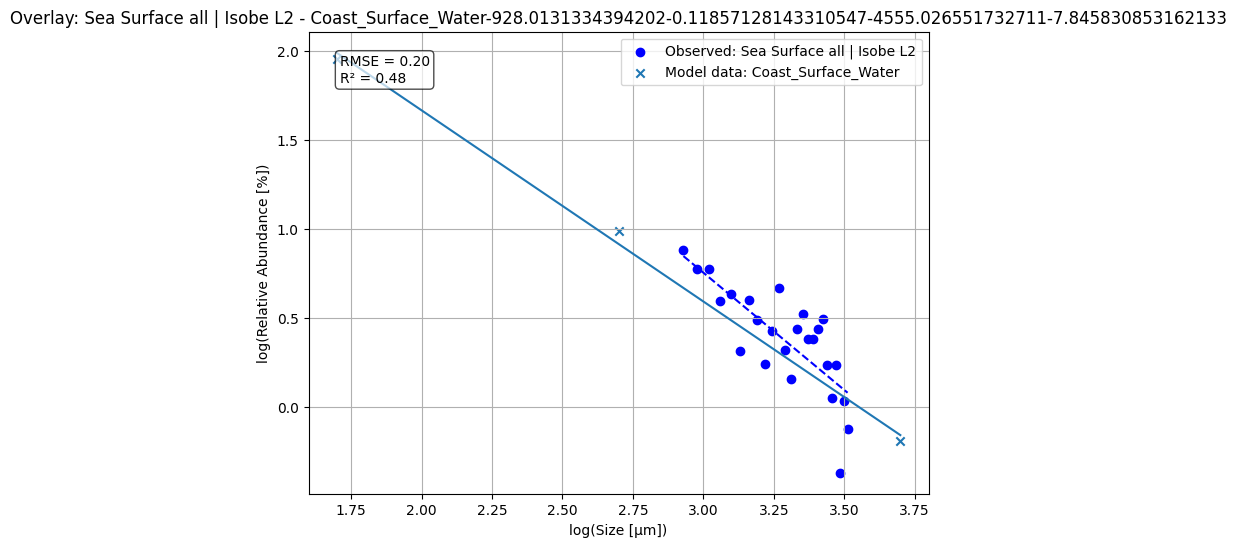

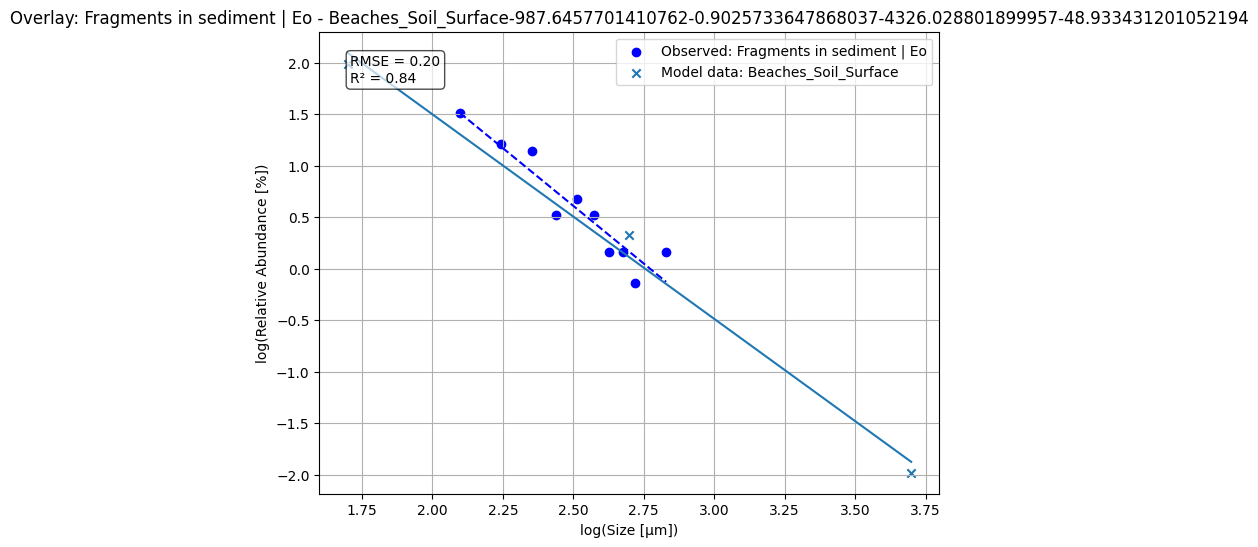

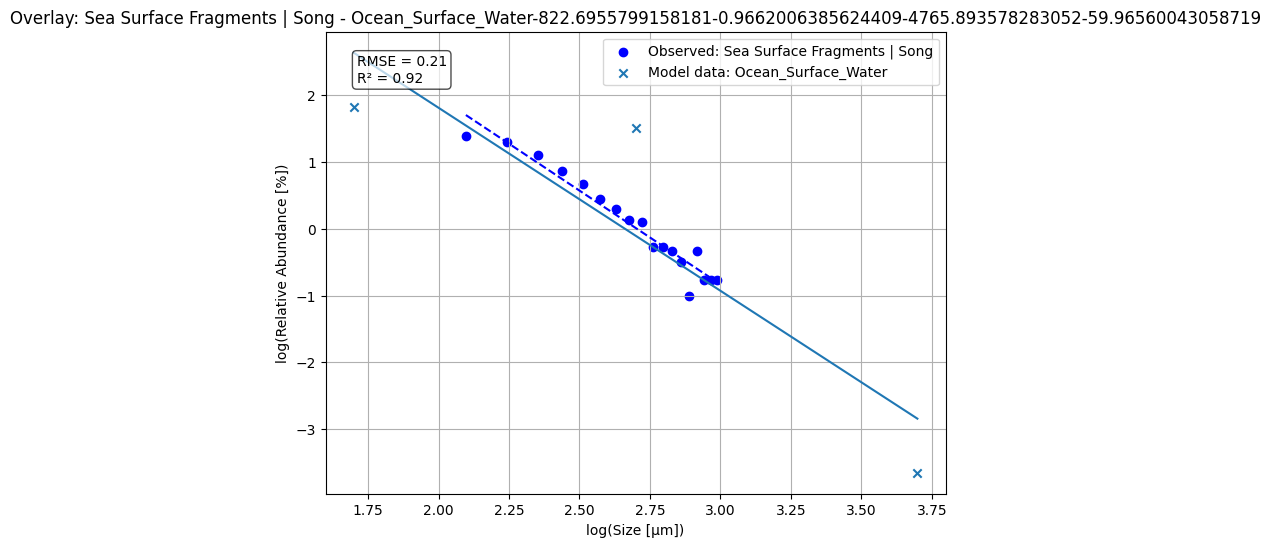

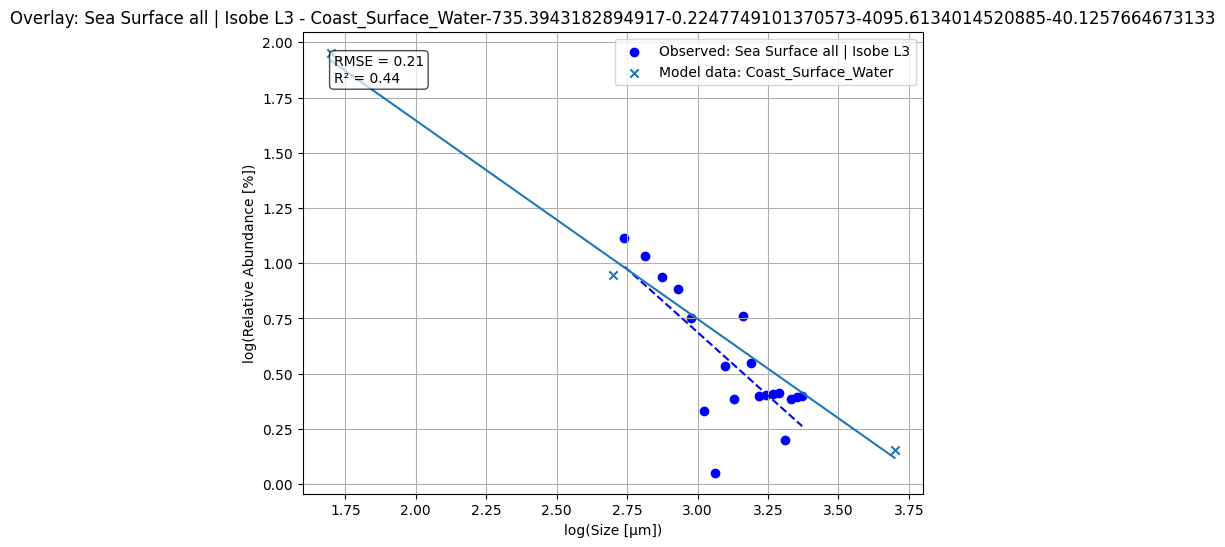

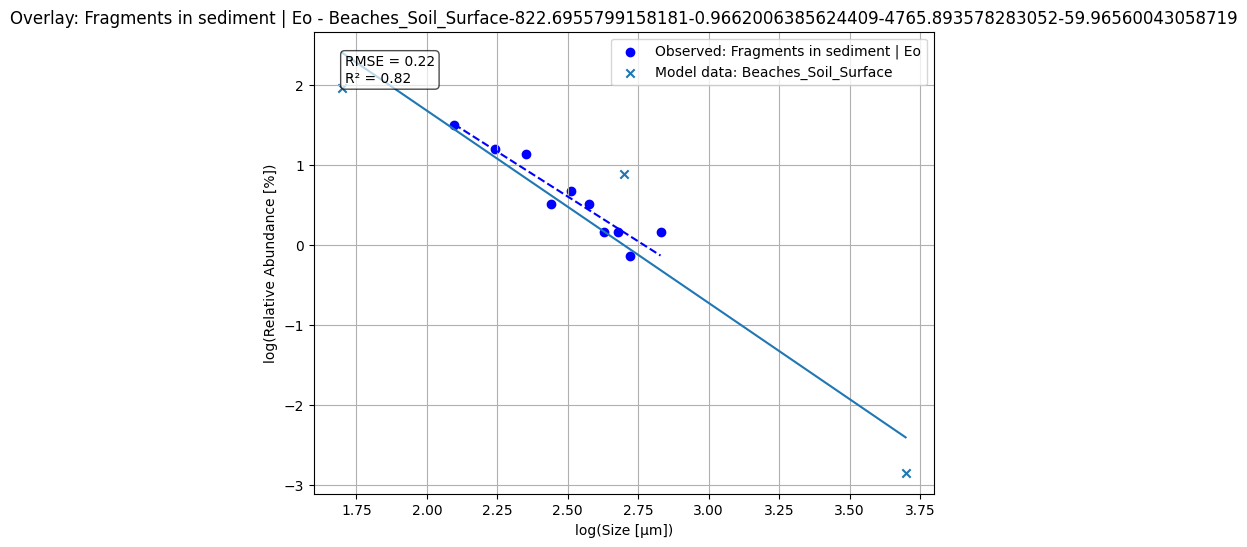

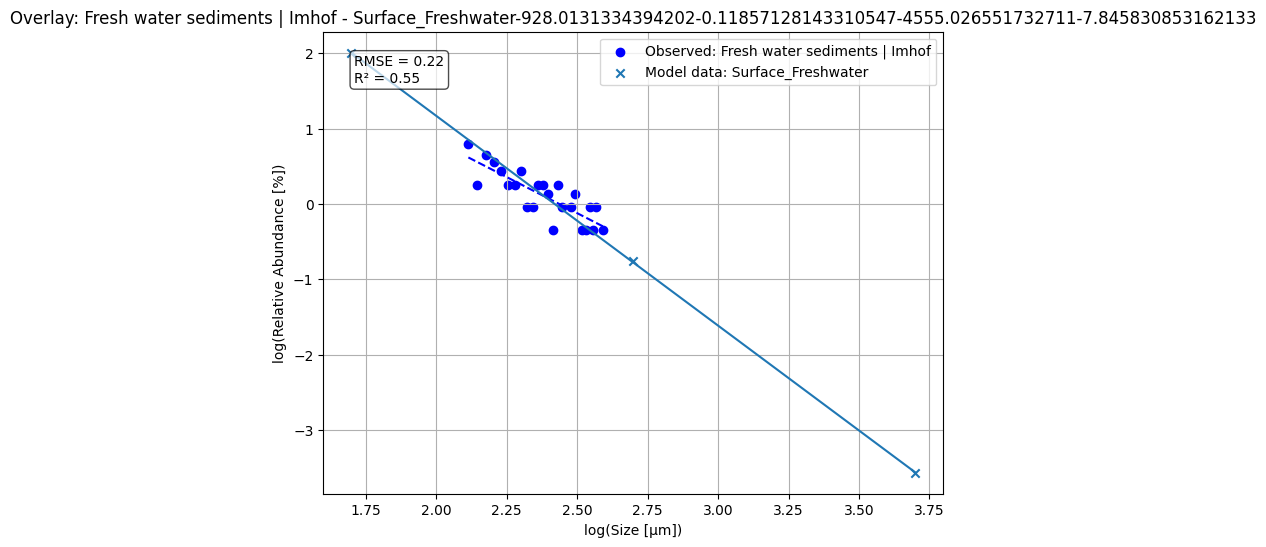

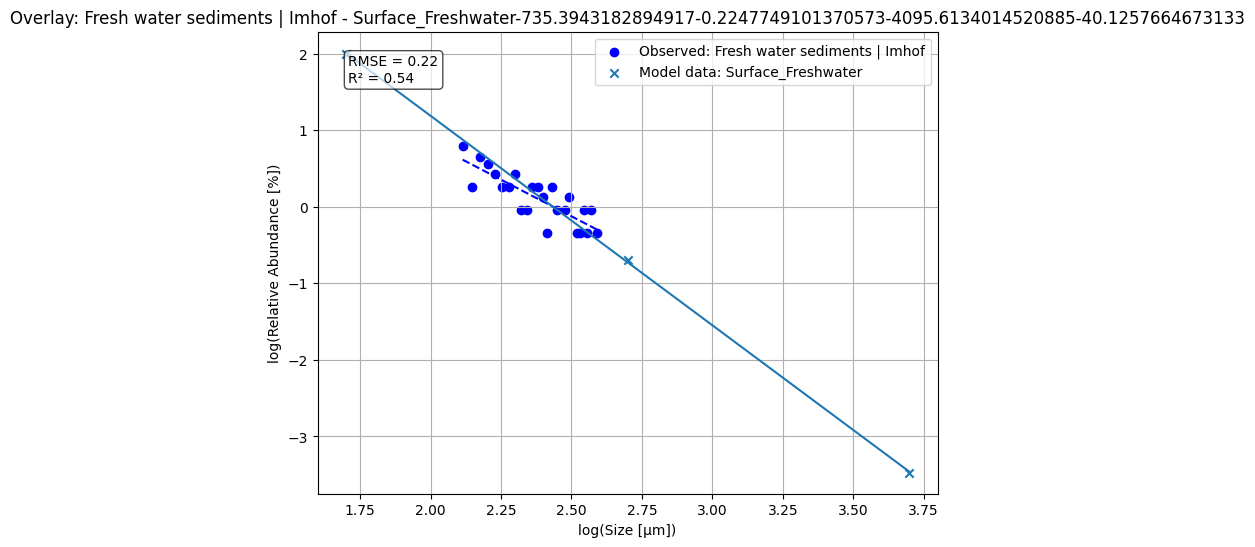

In [12]:
from utopia.monte_carlo.montecarlo_analysis_paper import run_and_plot_top_results
run_and_plot_top_results(top_results,data_data, config_data)

Correlation heat maps for top results

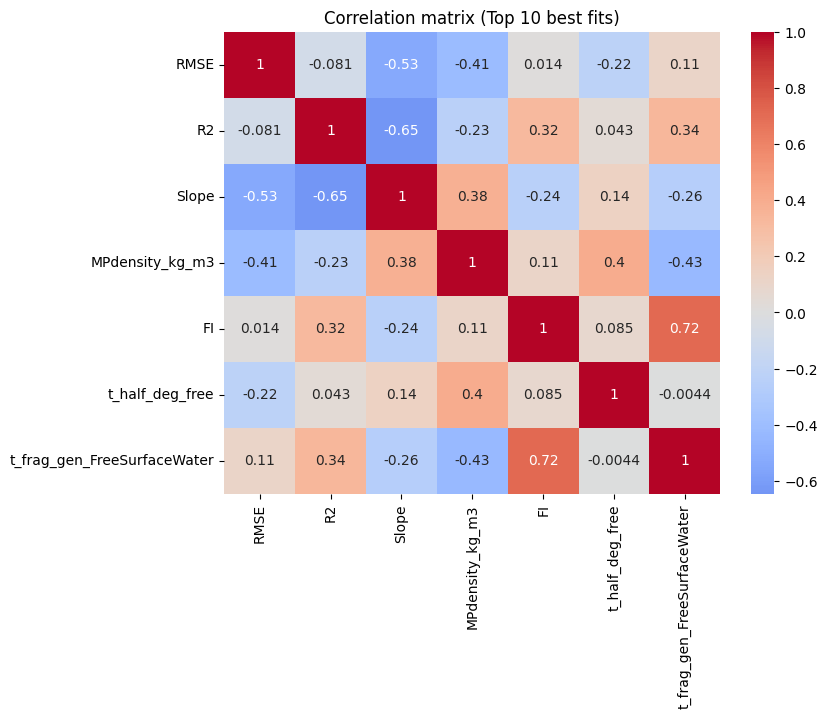

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = top_results[["RMSE", "R2", "Slope", "MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 10 best fits)")
plt.show()


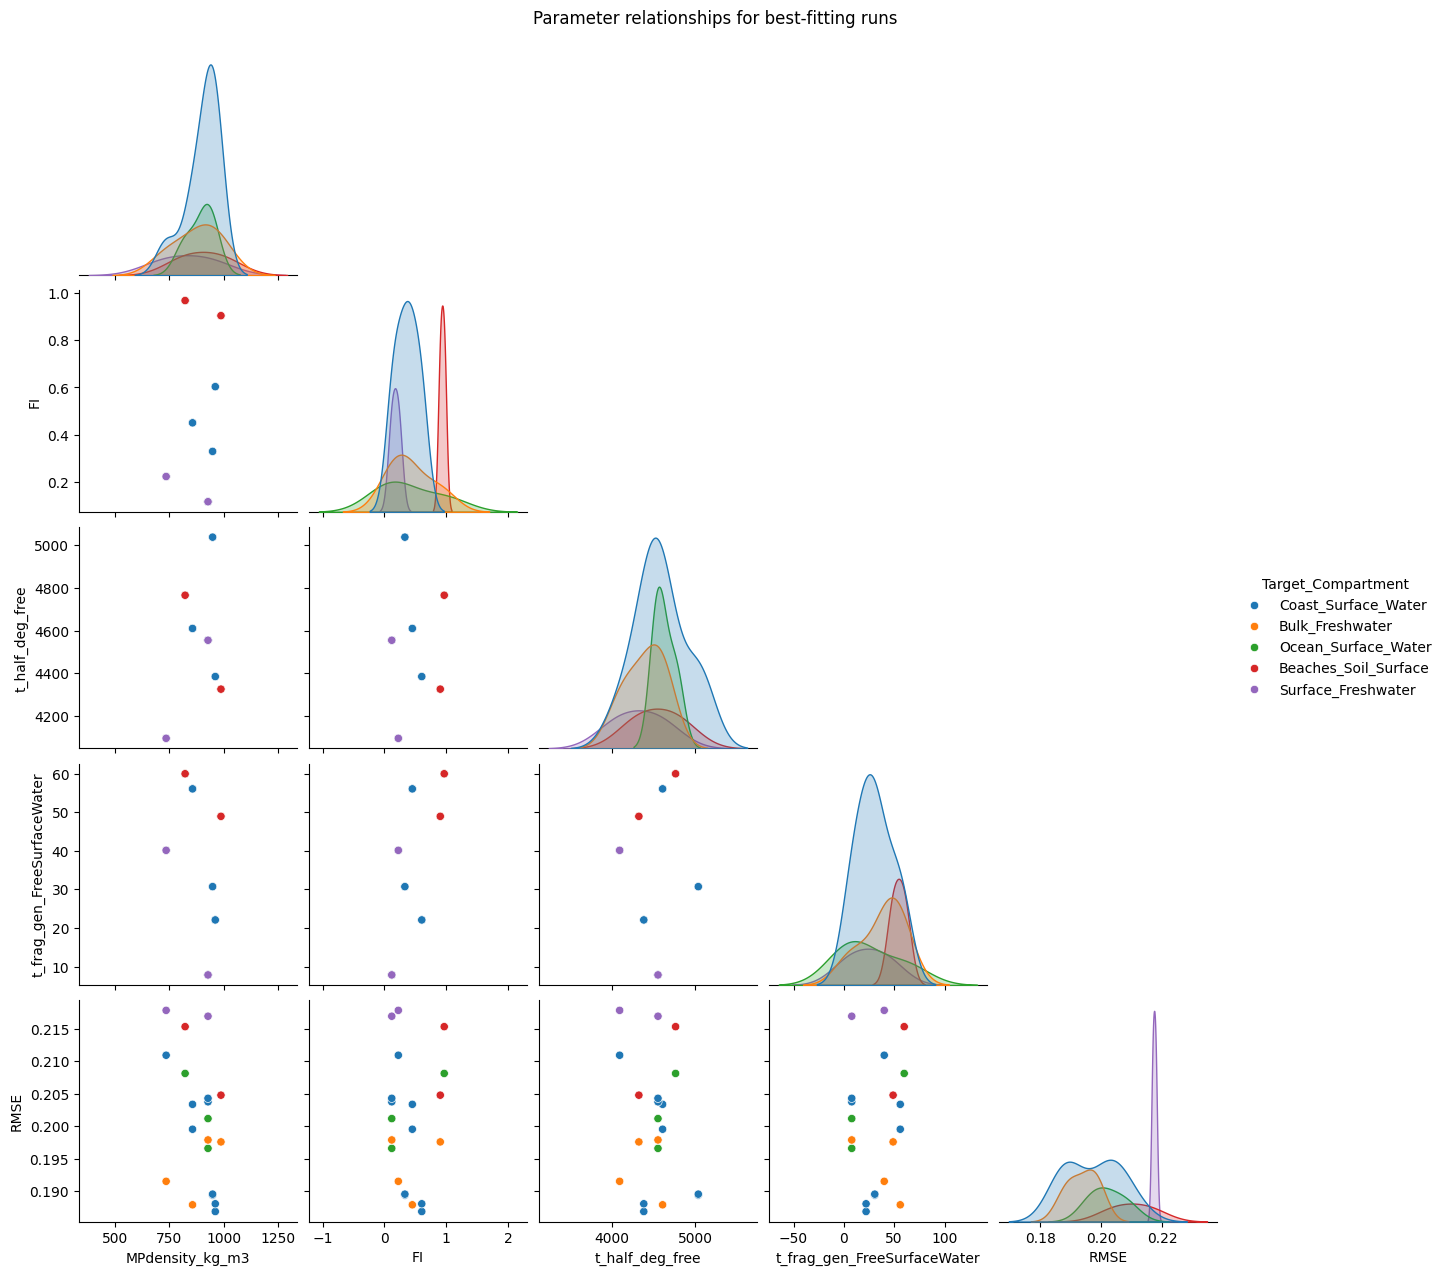

In [14]:
# Pair-wise relationships for the top results
sns.pairplot(
    top_results,
    vars=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","RMSE"],
    hue="Target_Compartment",
    corner=True
)
plt.suptitle("Parameter relationships for best-fitting runs", y=1.02)
plt.show()


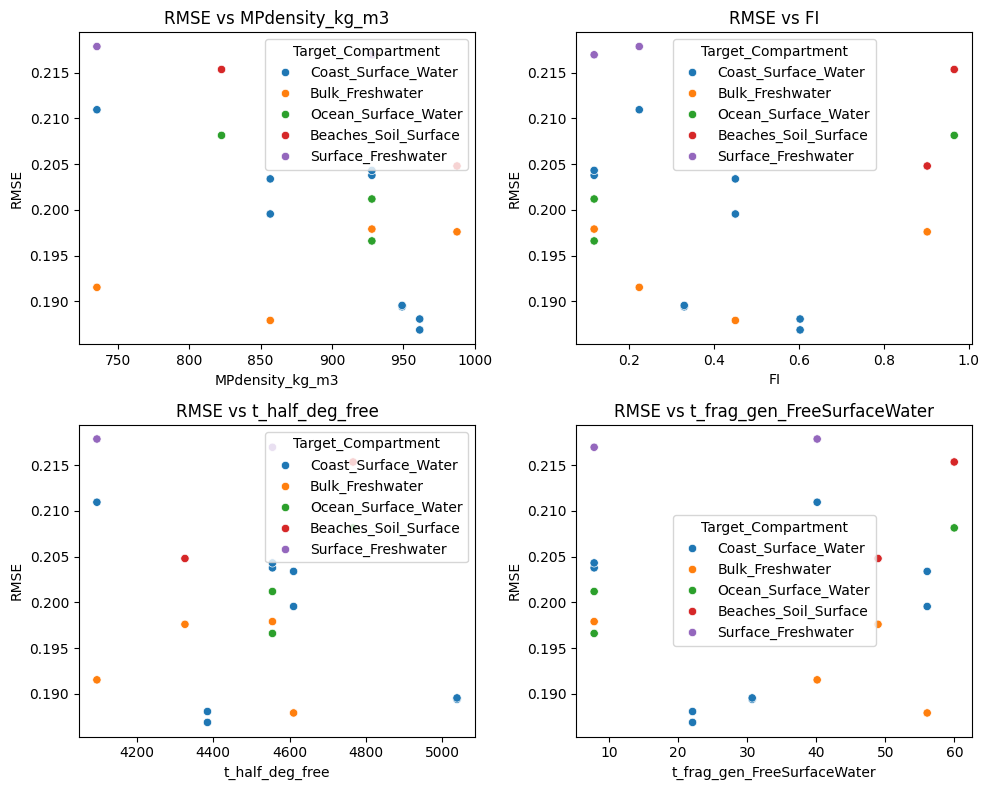

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

params = ["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]

for ax, param in zip(axes.ravel(), params):
    sns.scatterplot(data=top_results, x=param, y="RMSE", hue="Target_Compartment", ax=ax)
    ax.set_title(f"RMSE vs {param}")

plt.tight_layout()
plt.show()


Pearson r = 0.114, p = 6.323e-01
Spearman ρ = 0.130, p = 5.844e-01


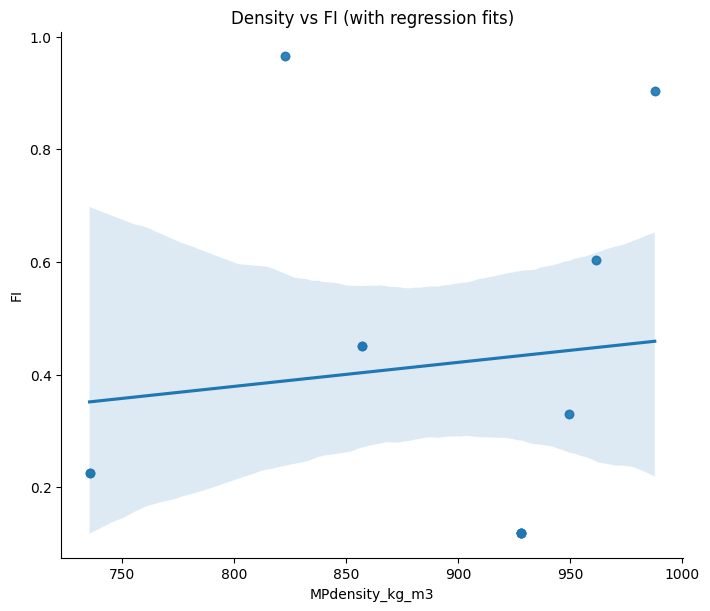

In [31]:
# Pearson & Spearman correlation between Density and FI for all results

# Pearson tests linear correlation.

# Spearman tests monotonic correlation (rank-based, robust to nonlinearities).

# If p < 0.05, the correlation is statistically significant.

from scipy.stats import pearsonr, spearmanr

x = top_results["MPdensity_kg_m3"]
y = top_results["FI"]

pearson_corr, pearson_p = pearsonr(x, y)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson r = {pearson_corr:.3f}, p = {pearson_p:.3e}")
print(f"Spearman ρ = {spearman_corr:.3f}, p = {spearman_p:.3e}")

import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=top_results, 
    x="MPdensity_kg_m3", 
    y="FI", 
    #hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()



Best fits Pearson r = 0.114


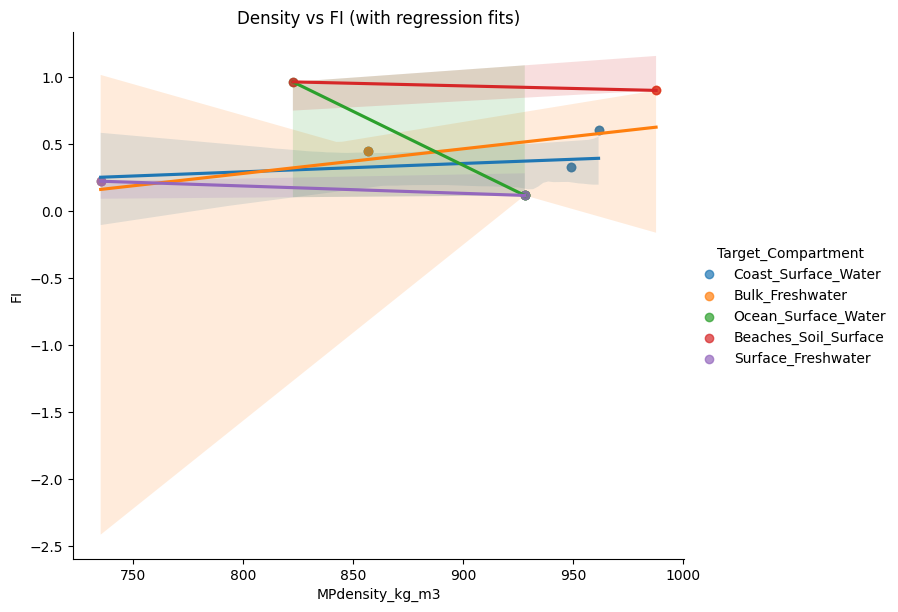

In [ ]:

# Pearson & Spearman correlation between Density and FI for best fits (e.g. lowest 10% RMSE)

threshold = top_results["RMSE"].quantile(0.1)  # lowest 10% of RMSE
best_fits = top_results[top_results["RMSE"] <= threshold]

pearson_corr, _ = pearsonr(best_fits["MPdensity_kg_m3"], best_fits["FI"])
print(f"Best fits Pearson r = {pearson_corr:.3f}")


sns.lmplot(
    data=best_fits, 
    x="MPdensity_kg_m3", 
    y="FI", 
    hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()

In [20]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# Keep only best 10% RMSE across all compartments
threshold = top_results["RMSE"].quantile(0.1)
best_fits = top_results[top_results["RMSE"] <= threshold]

results = []

for comp in best_fits["Target_Compartment"].unique():
    subset = best_fits[best_fits["Target_Compartment"] == comp]
    
    if len(subset) > 2:  # need at least 3 points
        pearson_corr, pearson_p = pearsonr(subset["MPdensity_kg_m3"], subset["FI"])
        spearman_corr, spearman_p = spearmanr(subset["MPdensity_kg_m3"], subset["FI"])
    else:
        pearson_corr, pearson_p, spearman_corr, spearman_p = [None]*4
    
    results.append({
        "Target_Compartment": comp,
        "Pearson_r": pearson_corr,
        "Pearson_p": pearson_p,
        "Spearman_rho": spearman_corr,
        "Spearman_p": spearman_p,
        "n_points": len(subset)
    })

correlation_best = pd.DataFrame(results)
print(correlation_best)


    Target_Compartment Pearson_r Pearson_p Spearman_rho Spearman_p  n_points
0  Coast_Surface_Water      None      None         None       None         1
1      Bulk_Freshwater      None      None         None       None         1


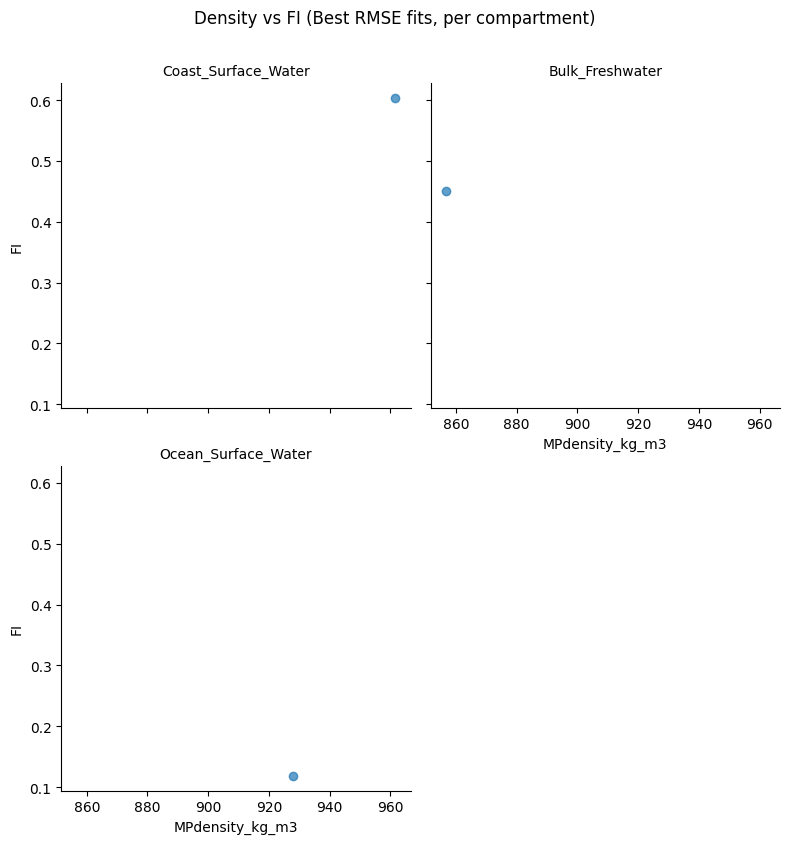

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- pick best fits per compartment (lowest 10% RMSE) ---
best_fits_list = []

for comp in top_results["Target_Compartment"].unique():
    subset = top_results[top_results["Target_Compartment"] == comp]
    if len(subset) > 2:
        threshold = subset["RMSE"].quantile(0.1)   # lowest 10%
        best_subset = subset[subset["RMSE"] <= threshold]
        best_fits_list.append(best_subset)

best_fits = pd.concat(best_fits_list, ignore_index=True)

# --- plot each compartment separately ---
g = sns.lmplot(
    data=best_fits,
    x="MPdensity_kg_m3",
    y="FI",
    col="Target_Compartment",   # separate plot per compartment
    col_wrap=2,                 # wrap panels (2 per row)
    height=4,
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "black"}
)

g.set_titles("{col_name}")
plt.suptitle("Density vs FI (Best RMSE fits, per compartment)", y=1.05)
plt.show()



### Plot sensitivity indices for each output variable.  Monaco uses the D-VARS approach to calculating global sensitivity indices.

In [23]:
sim.outvars

{'Spearman_r': <monaco.mc_var.OutVar at 0x16cc2281650>,
 'Spearman_p': <monaco.mc_var.OutVar at 0x16cbfaadc90>,
 'Pass_Spearman': <monaco.mc_var.OutVar at 0x16cbd9294d0>,
 'RMSE': <monaco.mc_var.OutVar at 0x16cbfb8df50>,
 'R_squared': <monaco.mc_var.OutVar at 0x16cbfb8c990>,
 'Model_slope': <monaco.mc_var.OutVar at 0x16cc1deb590>,
 'Model_intercept': <monaco.mc_var.OutVar at 0x16cc1deba90>,
 'Target_compartment': <monaco.mc_var.OutVar at 0x16cc1dea490>,
 'Emission_compartment': <monaco.mc_var.OutVar at 0x16cc1de8550>}

In [24]:
sim.calcSensitivities("C_g_m3_Ocean_Surface_Water")
fig, ax = sim.outvars["C_g_m3_Ocean_Surface_Water"].plotSensitivities()

KeyError: 'C_g_m3_Ocean_Surface_Water'

In [25]:
sim.calcSensitivities("persistence_number")
fig, ax = sim.outvars["persistence_number"].plotSensitivities()

KeyError: 'persistence_number'

Variable: Spearman_r
Calculating sensitivity indices for 'Spearman_r'...
Calculating optimal hyperparameters Φ for 'Spearman_r' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


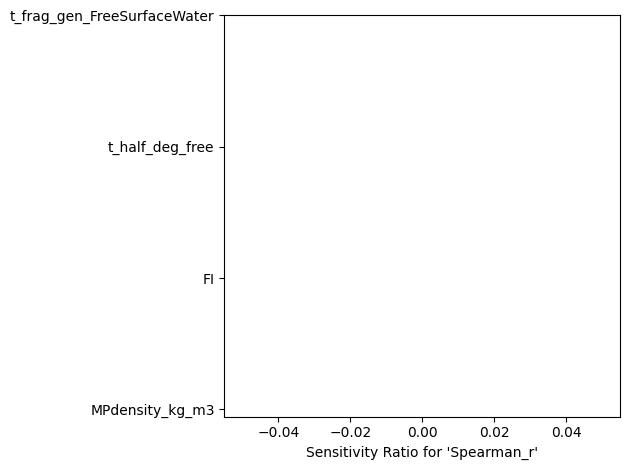

Variable: Spearman_p
Calculating sensitivity indices for 'Spearman_p'...
Calculating optimal hyperparameters Φ for 'Spearman_p' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


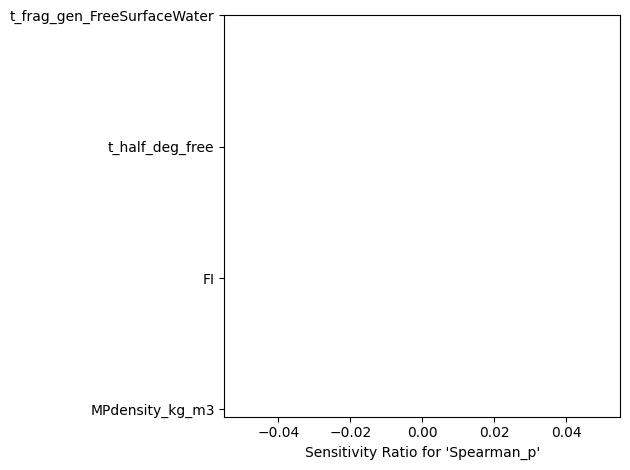

Variable: Pass_Spearman
Calculating sensitivity indices for 'Pass_Spearman'...
Calculating optimal hyperparameters Φ for 'Pass_Spearman' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


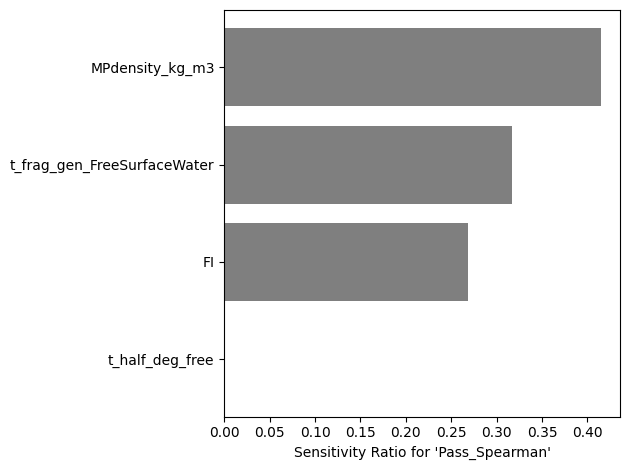

Variable: RMSE
Calculating sensitivity indices for 'RMSE'...
Calculating optimal hyperparameters Φ for 'RMSE' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


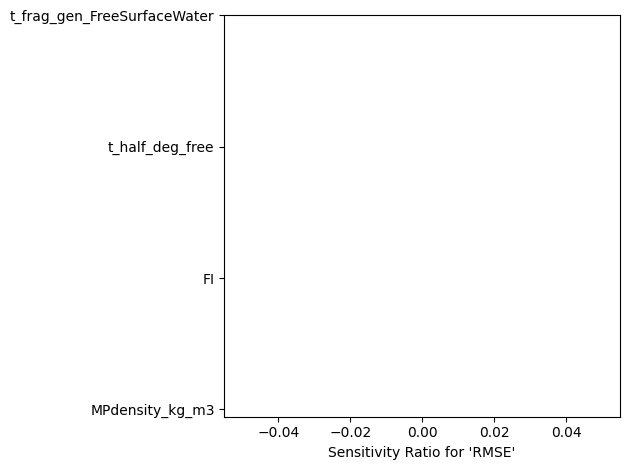

Variable: R_squared
Calculating sensitivity indices for 'R_squared'...
Calculating optimal hyperparameters Φ for 'R_squared' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


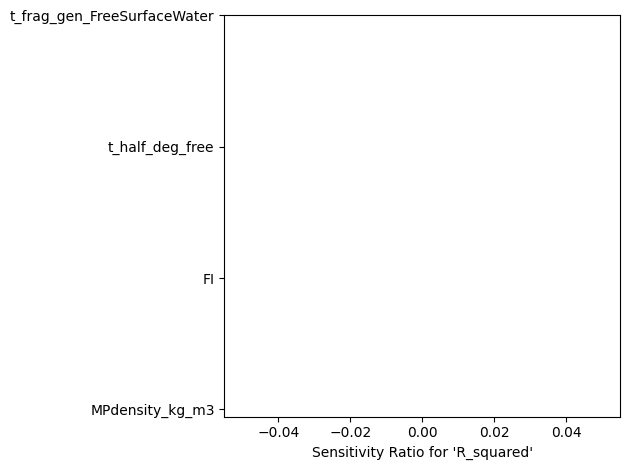

Variable: Model_slope
Calculating sensitivity indices for 'Model_slope'...
Calculating optimal hyperparameters Φ for 'Model_slope' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


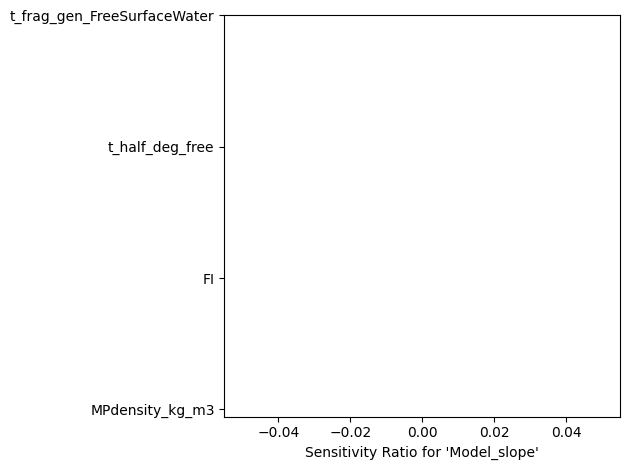

Variable: Model_intercept
Calculating sensitivity indices for 'Model_intercept'...
Calculating optimal hyperparameters Φ for 'Model_intercept' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


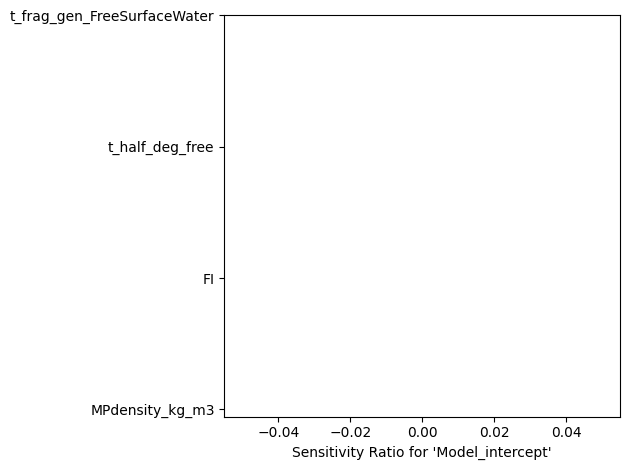

Variable: Target_compartment
Calculating sensitivity indices for 'Target_compartment'...
Calculating optimal hyperparameters Φ for 'Target_compartment' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:277: RuntimeWarning: divide by zero encountered in log
  L = np.log(Rdet)/m + m*np.log(L_inner.T @ Rinv @ L_inner)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:93: RuntimeWarning: invalid value encountered in divide
  ratios = sensitivities/sum(sensitivities)


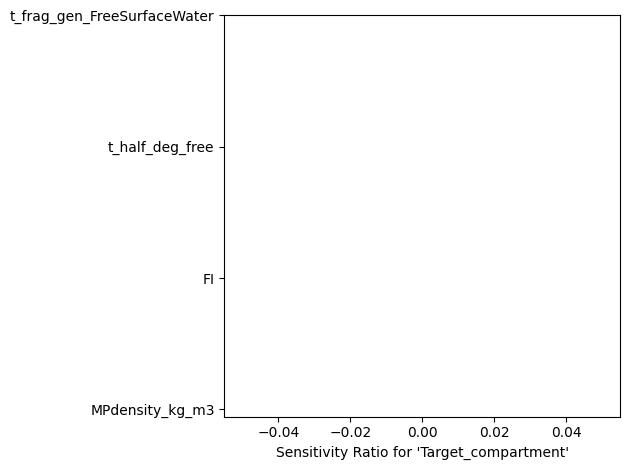

Variable: Emission_compartment
Calculating sensitivity indices for 'Emission_compartment'...
Calculating optimal hyperparameters Φ for 'Emission_compartment' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:277: RuntimeWarning: divide by zero encountered in log
  L = np.log(Rdet)/m + m*np.log(L_inner.T @ Rinv @ L_inner)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:93: RuntimeWarning: invalid value encountered in divide
  ratios = sensitivities/sum(sensitivities)


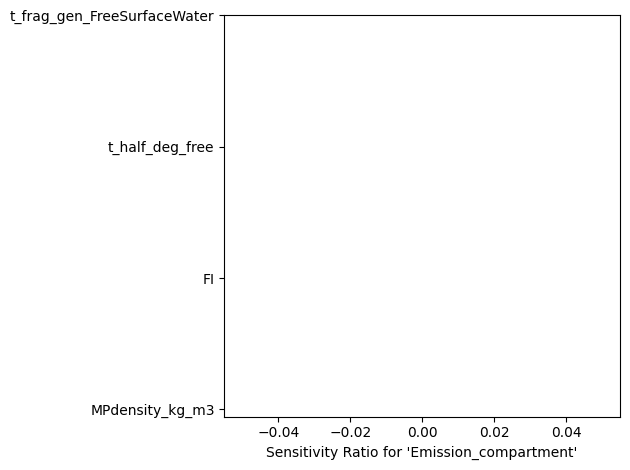

In [26]:
import matplotlib.pyplot as plt

for var in sim.outvars:
    print(f"Variable: {var}")
    sim.calcSensitivities(var)
    fig, ax = sim.outvars[var].plotSensitivities()

    plt.show()

### Plot 

In [80]:
sim.outvars.keys()

dict_keys(['Coast_Surface_Water_Spearman_r', 'Coast_Surface_Water_Spearman_p', 'Coast_Surface_Water_Pass_Spearman', 'Coast_Surface_Water_RMSE', 'Coast_Surface_Water_R_squared', 'Coast_Surface_Water_Model_slope', 'Coast_Surface_Water_Model_intercept', 'Ocean_Surface_Water_Spearman_r', 'Ocean_Surface_Water_Spearman_p', 'Ocean_Surface_Water_Pass_Spearman', 'Ocean_Surface_Water_RMSE', 'Ocean_Surface_Water_R_squared', 'Ocean_Surface_Water_Model_slope', 'Ocean_Surface_Water_Model_intercept', 'residence_time_mass', 'residence_time_number', 'persistence_mass', 'persistence_number'])

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='MPdensity_kg_m3'>,
  <Axes: ylabel='persistence_mass'>,
  <Axes: >))

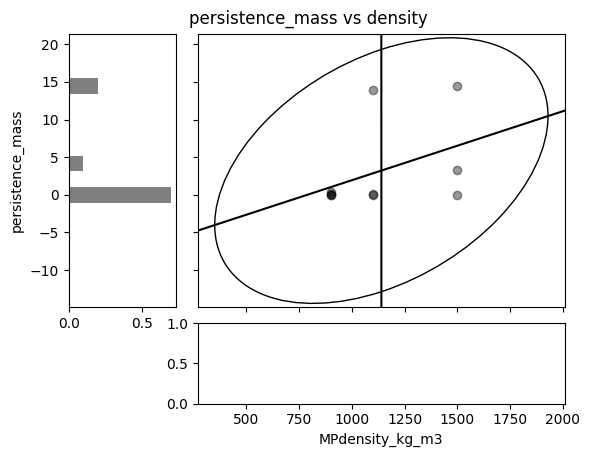

In [81]:

mc.multi_plot([sim.invars["MPdensity_kg_m3"],sim.outvars["persistence_mass"]],title="persistence_mass vs density",cov_plot=True)